# INTRODUCTION

The data was sourced from https://data.iowa.gov/Sales-Distribution/Iowa-Liquor-Sales/m3tr-qhgy/about_data.

This dataset contains the spirits purchase information of Iowa Class “E” liquor licensees by product and date of purchase from 1 January 2013 to 31 December 2023.  Class E liquor license, for grocery stores, liquor stores, convenience stores, etc., allows commercial establishments to sell liquor for off-premises consumption in original unopened containers.

The purpose of this analysis is to identify the fastest growing liquor category over the last 11 years and the characteristics of successful items within this category.

In [1]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
import calendar
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy.stats import linregress

In [2]:
# setting configurations
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [3]:
# linking google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 01. Importing & Cleaning Data

In [4]:
# importing iowa liquor data
df = pd.read_csv('/content/drive/MyDrive/Iowa_Liquor_Sales_20240220.csv')
df.head()

,Date,Store Name,Address,City,Zip Code,County,Category,Category Name,Vendor Name,Item Number,Item Description,Bottle Volume (ml),State Bottle Cost,State Bottle Retail,Bottles Sold,Sale (Dollars),Volume Sold (Liters)
0,10/23/2022,DEPOT LIQUOR & GROCERY / MARSHALLTOWN,114 CENTER ST.,MARSHALLTOWN,50158.0,MARSHALL,1701100.0,TEMPORARY & SPECIALTY PACKAGES,BACARDI USA INC,4532,DEWARS DOUBLE DOUBLE 21,750,49.99,74.99,3,224.97,2.25
1,10/24/2022,FAREWAY STORES #183 / FLEUR,4313 FLEUR DR,DES MOINES,50321.0,POLK,1012100.0,CANADIAN WHISKIES,JIM BEAM BRANDS,10628,CANADIAN CLUB WHISKY,1750,14.50,21.75,6,130.50,10.50
2,10/24/2022,JEFF'S MARKET / BLUE GRASS,"102, W MAYNE ST",BLUE GRASS,52726.0,SCOTT,1012100.0,CANADIAN WHISKIES,DIAGEO AMERICAS,11290,CROWN ROYAL MINI,50,9.95,14.93,1,14.93,0.05
3,10/21/2022,HY-VEE WINE AND SPIRITS / SHENANDOAH,520 SO FREMONT,SHENANDOAH,51601.0,PAGE,1012100.0,CANADIAN WHISKIES,DIAGEO AMERICAS,11298,CROWN ROYAL,1750,33.99,50.99,6,305.94,10.50
4,10/25/2022,CASEY'S GENERAL STORE #3648 / AKRON,80 SOUTH ST,AKRON,51001.0,PLYMOUTH,1012100.0,CANADIAN WHISKIES,HEAVEN HILL BRANDS,11788,BLACK VELVET,1750,10.45,15.68,6,94.08,10.50


In [5]:
# checking shape of data
df.shape

(26094313, 17)

In [6]:
# renaming columns for ease of use
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [7]:
# check data types of colums
df.dtypes

date                     object
store_name               object
address                  object
city                     object
zip_code                 object
county                   object
category                float64
category_name            object
vendor_name              object
item_number              object
item_description         object
bottle_volume_(ml)        int64
state_bottle_cost       float64
state_bottle_retail     float64
bottles_sold              int64
sale_(dollars)          float64
volume_sold_(liters)    float64
dtype: object

In [8]:

# check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
date                         0
store_name                   0
address                  83090
city                     83089
zip_code                 83156
county                  156293
category                 16690
category_name            24218
vendor_name                  7
item_number                  0
item_description             0
bottle_volume_(ml)           0
state_bottle_cost            0
state_bottle_retail          0
bottles_sold                 0
sale_(dollars)               0
volume_sold_(liters)         0
dtype: int64


The code below creates a mapping dictionary where the keys are the non-null values in the "store_name" column, and the corresponding values are the non-null values in the city, zip_code and county columns associated with those store names.

Then, it iterates over each row in the DataFrame (df) and for each row, it checks if the city, zip_code or county value is missing. If it is missing, it looks up the corresponding "store_name" value for that row in the mapping dictionary to find the associated missing value. This way, it fills in the missing values based on the "store_name" column.

In [9]:
# create mapping dictionaries
city_mapping_dict = df.dropna(subset=['city', 'store_name']).set_index('store_name')['city'].to_dict()
zip_mapping_dict = df.dropna(subset=['zip_code', 'store_name']).set_index('store_name')['zip_code'].to_dict()
county_mapping_dict = df.dropna(subset=['county', 'store_name']).set_index('store_name')['county'].to_dict()

# fill missing values in 'city', 'zip_code', and 'county' columns
df['city'] = df['store_name'].map(city_mapping_dict).fillna(df['city'])
df['zip_code'] = df['store_name'].map(zip_mapping_dict).fillna(df['zip_code'])
df['county'] = df['store_name'].map(county_mapping_dict).fillna(df['county'])

Now lets do the same for the missing category_names and vendor_names but using chunks as the memory usage is quite intensive.

In [10]:
# create mapping dictionaries for category name and vendor name
category_mapping_dict = df.dropna(subset=['category_name', 'item_description']).set_index('item_description')['category_name'].to_dict()
vendor_mapping_dict = df.dropna(subset=['vendor_name', 'item_description']).set_index('item_description')['vendor_name'].to_dict()

# fill missing values in 'category_name' and 'vendor_name' columns
df['category_name'] = df['item_description'].map(category_mapping_dict).fillna(df['category_name'])
df['vendor_name'] = df['item_description'].map(vendor_mapping_dict).fillna(df['vendor_name'])

In [11]:
# check for missing values
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
date                        0
store_name                  0
address                 83090
city                      904
zip_code                  904
county                   1919
category                16690
category_name            4107
vendor_name                 2
item_number                 0
item_description            0
bottle_volume_(ml)          0
state_bottle_cost           0
state_bottle_retail         0
bottles_sold                0
sale_(dollars)              0
volume_sold_(liters)        0
dtype: int64


These missing values account for an extremely small percentage of the total 26,000,000+ rows so we will go ahead and remove them.

In [12]:
# drop rows with missing values
df.dropna(inplace=True)

In [13]:
# saving clean dataset
df.to_csv('/content/drive/MyDrive/iowa_liquor_final.csv', index=False)

# 2. CATEGORY GROWTH RATES

In [14]:
# importing clean data
df = pd.read_csv('/content/drive/MyDrive/iowa_liquor_final.csv')
df.head()

,date,store_name,address,city,zip_code,county,category,category_name,vendor_name,item_number,item_description,bottle_volume_(ml),state_bottle_cost,state_bottle_retail,bottles_sold,sale_(dollars),volume_sold_(liters)
0,10/23/2022,DEPOT LIQUOR & GROCERY / MARSHALLTOWN,114 CENTER ST.,MARSHALLTOWN,50158.0,MARSHALL,1701100.0,TEMPORARY & SPECIALTY PACKAGES,BACARDI USA INC,4532,DEWARS DOUBLE DOUBLE 21,750,49.99,74.99,3,224.97,2.25
1,10/24/2022,FAREWAY STORES #183 / FLEUR,4313 FLEUR DR,DES MOINES,50321.0,POLK,1012100.0,CANADIAN WHISKIES,JIM BEAM BRANDS,10628,CANADIAN CLUB WHISKY,1750,14.50,21.75,6,130.50,10.50
2,10/24/2022,JEFF'S MARKET / BLUE GRASS,"102, W MAYNE ST",BLUE GRASS,52726.0,SCOTT,1012100.0,CANADIAN WHISKIES,DIAGEO AMERICAS,11290,CROWN ROYAL MINI,50,9.95,14.93,1,14.93,0.05
3,10/21/2022,HY-VEE WINE AND SPIRITS / SHENANDOAH,520 SO FREMONT,SHENANDOAH,51601.0,PAGE,1012100.0,CANADIAN WHISKIES,DIAGEO AMERICAS,11298,CROWN ROYAL,1750,33.99,50.99,6,305.94,10.50
4,10/25/2022,CASEY'S GENERAL STORE #3648 / AKRON,80 SOUTH ST,AKRON,51001.0,PLYMOUTH,1012100.0,CANADIAN WHISKIES,HEAVEN HILL BRANDS,11788,BLACK VELVET,1750,10.45,15.68,6,94.08,10.50


To look at the category growth rates over the 10 years we first need to identify if all categories were present in each year or if some categories were removed or added during the time period.

In [15]:
# convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# extract year from the 'date' column
df['year'] = df['date'].dt.year

# group data by year and category_name, then count the number of unique categories for each year
categories_by_year = df.groupby('year')['category_name'].nunique()

print("Number of Categories in Each Year:")
print(categories_by_year)

Number of Categories in Each Year:
year
2013    91
2014    91
2015    94
2016    94
2017    89
2018    82
2019    77
2020    74
2021    73
2022    61
2023    54
Name: category_name, dtype: int64


In [16]:
# extract unique category names
category_names = df['category_name'].unique()

# print the list of category names
print("List of Category Names:")
for category_name in category_names:
    print(category_name)

List of Category Names:
TEMPORARY & SPECIALTY PACKAGES
CANADIAN WHISKIES
AMERICAN VODKAS
STRAIGHT BOURBON WHISKIES
AMERICAN FLAVORED VODKA
IMPORTED DISTILLED SPIRITS SPECIALTY
BLENDED WHISKIES
COFFEE LIQUEURS
AMERICAN BRANDIES
AMERICAN SCHNAPPS
IMPORTED CORDIALS & LIQUEURS
MIXTO TEQUILA
WHITE RUM
SPICED RUM
WHISKEY LIQUEUR
COCKTAILS/RTD
100% AGAVE TEQUILA
AMERICAN CORDIALS & LIQUEURS
CREAM LIQUEURS
FLAVORED RUM
IMPORTED FLAVORED VODKA
GOLD RUM
AMERICAN DRY GINS
IMPORTED VODKAS
IMPORTED SCHNAPPS
AGED DARK RUM
TENNESSEE WHISKIES
NEUTRAL GRAIN SPIRITS
IRISH WHISKIES
IMPORTED BRANDIES
NEUTRAL GRAIN SPIRITS FLAVORED
STRAIGHT RYE WHISKIES
BOTTLED IN BOND BOURBON
SINGLE MALT SCOTCH
IMPORTED DRY GINS
SCOTCH WHISKIES
AMERICAN DISTILLED SPIRITS SPECIALTY
TRIPLE SEC
SINGLE BARREL BOURBON WHISKIES
FLAVORED GIN
CORN WHISKIES
MEZCAL
SPECIAL ORDER ITEMS
AMERICAN SLOE GINS
PEPPERMINT SCHNAPPS
TEQUILA
VODKA FLAVORED
IMPORTED VODKA - MISC
DARK CREME DE CACAO
BARBADOS RUM
MISCELLANEOUS SCHNAPPS
PUERTO RI

The categories will be grouped together into 10 broader categories as outlined below, these categories will then span the entire time period.

1. Whiskey:
   - CANADIAN WHISKIES
   - STRAIGHT BOURBON WHISKIES
   - BLENDED WHISKIES
   - TENNESSEE WHISKIES
   - STRAIGHT RYE WHISKIES
   - BOTTLED IN BOND BOURBON
   - SINGLE MALT SCOTCH
   - JAPANESE WHISKY
   - IOWA DISTILLERY WHISKIES
   - IRISH WHISKIES
   - SCOTCH WHISKIES
   - SINGLE BARREL BOURBON WHISKIES
   - CORN WHISKIES
   - IOWA DISTILLERIES

2. Vodka:
   - AMERICAN VODKAS
   - IMPORTED VODKAS
   - VODKA FLAVORED
   - VODKA 80 PROOF
   - 100 PROOF VODKA
   - OTHER PROOF VODKA
   - LOW PROOF VODKA
   - IMPORTED VODKA - CHERRY
   - AMERICAN FLAVORED VODKA
   - IMPORTED FLAVORED VODKA
   - IMPORTED VODKA - MISC

3. Cocktails:
   - AMERICAN COCKTAILS
   - COCKTAILS/RTD

4. Gins and Neutral Spirits:
   - FLAVORED GIN
   - NEUTRAL GRAIN SPIRITS FLAVORED
   - NEUTRAL GRAIN SPIRITS
   - AMERICAN DRY GINS
   - IMPORTED DRY GINS
   - AMERICAN SLOE GINS
   - FLAVORED GINS
   - AMERICAN ALCOHOL

5. Liqueur:
   - COFFEE LIQUEURS
   - WHISKEY LIQUEUR
   - CREAM LIQUEURS
   - IMPORTED CORDIALS & LIQUEURS
   - AMERICAN CORDIALS & LIQUEURS
   - MISC. IMPORTED CORDIALS & LIQUEURS
   - WHITE CREME DE CACAO
   - DARK CREME DE CACAO
   - GREEN CREME DE MENTHE
   - WHITE CREME DE MENTHE
   - ANISETTE
   - TRIPLE SEC
   - MISC. AMERICAN CORDIALS & LIQUEURS
   - ROCK & RYE
   - AMERICAN AMARETTO
   - AMARETTO - IMPORTED
   - CREME DE ALMOND

6. Rum:
   - WHITE RUM
   - SPICED RUM
   - GOLD RUM
   - AGED DARK RUM
   - BARBADOS RUM
   - PUERTO RICO & VIRGIN ISLANDS RUM
   - JAMAICA RUM
   - FLAVORED RUM

7. Tequila:
   - MIXTO TEQUILA
   - 100% AGAVE TEQUILA
   - TEQUILA
   - MEZCAL

8. Brandy:
   - AMERICAN BRANDIES
   - IMPORTED BRANDIES
   - AMERICAN GRAPE BRANDIES
   - IMPORTED GRAPE BRANDIES
   - MISC. BRANDIES
   - APRICOT BRANDIES
   - CHERRY BRANDIES
   - BLACKBERRY BRANDIES
   - PEACH BRANDIES
   - MISCELLANEOUS  BRANDIES

9. Schnapps:
   - AMERICAN SCHNAPPS
   - IMPORTED SCHNAPPS
   - PEPPERMINT SCHNAPPS
   - CHERRY SCHNAPPS
   - BUTTERSCOTCH SCHNAPPS
   - ROOT BEER SCHNAPPS
   - WATERMELON SCHNAPPS
   - CINNAMON SCHNAPPS
   - GRAPE SCHNAPPS
   - RASPBERRY SCHNAPPS
   - TROPICAL FRUIT SCHNAPPS
   - APPLE SCHNAPPS
   - MISCELLANEOUS SCHNAPPS
   - SCHNAPPS - IMPORTED
   - PEACH SCHNAPPS

10. Other:
    - IMPORTED DISTILLED SPIRITS SPECIALTY
    - AMERICAN DISTILLED SPIRITS SPECIALTY
    - SPECIAL ORDER ITEMS
    - DE LISTED / SPECIAL ORDER ITEMS
    - DECANTERS & SPECIALTY PACKAGES
    - HIGH PROOF BEER - AMERICAN
    - HOLIDAY VAP



In [17]:
# define a function to map each category name to its corresponding category
def map_category(category_name):
    if category_name in ['CANADIAN WHISKIES', 'STRAIGHT BOURBON WHISKIES', 'BLENDED WHISKIES',
                         'TENNESSEE WHISKIES', 'STRAIGHT RYE WHISKIES', 'BOTTLED IN BOND BOURBON',
                         'SINGLE MALT SCOTCH', 'JAPANESE WHISKY', 'IOWA DISTILLERY WHISKIES', 'IRISH WHISKIES',
                         'SCOTCH WHISKIES', 'SINGLE BARREL BOURBON WHISKIES', 'CORN WHISKIES', 'IOWA DISTILLERIES']:
        return 'WHISKEY'
    elif category_name in ['AMERICAN VODKAS', 'IMPORTED VODKAS', 'VODKA FLAVORED', 'VODKA 80 PROOF',
                           '100 PROOF VODKA', 'OTHER PROOF VODKA', 'LOW PROOF VODKA', 'IMPORTED VODKA - CHERRY',
                           'AMERICAN FLAVORED VODKA', 'IMPORTED FLAVORED VODKA', 'IMPORTED VODKA - MISC']:
        return 'VODKA'
    elif category_name in ['AMERICAN COCKTAILS', 'COCKTAILS/RTD']:
        return 'COCKTAILS'
    elif category_name in ['FLAVORED GIN', 'NEUTRAL GRAIN SPIRITS FLAVORED', 'NEUTRAL GRAIN SPIRITS', 'AMERICAN DRY GINS',
                           'IMPORTED DRY GINS', 'AMERICAN SLOE GINS', 'FLAVORED GINS', 'AMERICAN ALCOHOL']:
        return 'GINS AND NEUTRAL SPIRITS'
    elif category_name in ['COFFEE LIQUEURS', 'WHISKEY LIQUEUR', 'CREAM LIQUEURS', 'IMPORTED CORDIALS & LIQUEURS',
                           'AMERICAN CORDIALS & LIQUEURS', 'MISC. IMPORTED CORDIALS & LIQUEURS', 'WHITE CREME DE CACAO', 'AMARETTO - IMPORTED',
                           'DARK CREME DE CACAO', 'GREEN CREME DE MENTHE', 'WHITE CREME DE MENTHE', 'ANISETTE', 'AMERICAN AMARETTO',
                           'TRIPLE SEC', 'MISC. AMERICAN CORDIALS & LIQUEURS', 'ROCK & RYE', 'IMPORTED AMARETTO', 'CREME DE ALMOND' ]:
        return 'LIQUEUR'
    elif category_name in ['WHITE RUM', 'SPICED RUM', 'GOLD RUM', 'AGED DARK RUM', 'BARBADOS RUM',
                           'PUERTO RICO & VIRGIN ISLANDS RUM', 'JAMAICA RUM', 'FLAVORED RUM']:
        return 'RUM'
    elif category_name in ['MIXTO TEQUILA', '100% AGAVE TEQUILA', 'TEQUILA', 'MEZCAL']:
        return 'TEQUILA'
    elif category_name in ['AMERICAN BRANDIES', 'IMPORTED BRANDIES', 'AMERICAN GRAPE BRANDIES', 'IMPORTED GRAPE BRANDIES',
                           'MISC. BRANDIES', 'APRICOT BRANDIES', 'CHERRY BRANDIES', 'BLACKBERRY BRANDIES', 'PEACH BRANDIES',
                           'MISCELLANEOUS  BRANDIES']:
        return 'BRANDY'
    elif category_name in ['AMERICAN SCHNAPPS', 'IMPORTED SCHNAPPS', 'PEPPERMINT SCHNAPPS', 'CHERRY SCHNAPPS', 'PEACH SCHNAPPS',
                           'BUTTERSCOTCH SCHNAPPS', 'ROOT BEER SCHNAPPS', 'WATERMELON SCHNAPPS', 'CINNAMON SCHNAPPS', 'SCHNAPPS - IMPORTED',
                           'GRAPE SCHNAPPS', 'RASPBERRY SCHNAPPS', 'TROPICAL FRUIT SCHNAPPS', 'APPLE SCHNAPPS', 'MISCELLANEOUS SCHNAPPS']:
        return 'SCHNAPPS'
    else:
        return 'OTHER'

# apply the function to create a new column 'category_new'
df['category_new'] = df['category_name'].apply(map_category)

df.head()

,date,store_name,address,city,zip_code,county,category,category_name,vendor_name,item_number,item_description,bottle_volume_(ml),state_bottle_cost,state_bottle_retail,bottles_sold,sale_(dollars),volume_sold_(liters),year,category_new
0,2022-10-23,DEPOT LIQUOR & GROCERY / MARSHALLTOWN,114 CENTER ST.,MARSHALLTOWN,50158.0,MARSHALL,1701100.0,TEMPORARY & SPECIALTY PACKAGES,BACARDI USA INC,4532,DEWARS DOUBLE DOUBLE 21,750,49.99,74.99,3,224.97,2.25,2022,OTHER
1,2022-10-24,FAREWAY STORES #183 / FLEUR,4313 FLEUR DR,DES MOINES,50321.0,POLK,1012100.0,CANADIAN WHISKIES,JIM BEAM BRANDS,10628,CANADIAN CLUB WHISKY,1750,14.50,21.75,6,130.50,10.50,2022,WHISKEY
2,2022-10-24,JEFF'S MARKET / BLUE GRASS,"102, W MAYNE ST",BLUE GRASS,52726.0,SCOTT,1012100.0,CANADIAN WHISKIES,DIAGEO AMERICAS,11290,CROWN ROYAL MINI,50,9.95,14.93,1,14.93,0.05,2022,WHISKEY
3,2022-10-21,HY-VEE WINE AND SPIRITS / SHENANDOAH,520 SO FREMONT,SHENANDOAH,51601.0,PAGE,1012100.0,CANADIAN WHISKIES,DIAGEO AMERICAS,11298,CROWN ROYAL,1750,33.99,50.99,6,305.94,10.50,2022,WHISKEY
4,2022-10-25,CASEY'S GENERAL STORE #3648 / AKRON,80 SOUTH ST,AKRON,51001.0,PLYMOUTH,1012100.0,CANADIAN WHISKIES,HEAVEN HILL BRANDS,11788,BLACK VELVET,1750,10.45,15.68,6,94.08,10.50,2022,WHISKEY


In [18]:
# creatung new column for the cost of the bottles sold (i.e. without the state markup)
df['sale_(dollars)_cost'] = df['bottles_sold'] * df['state_bottle_cost']

In [19]:
# saving new dataset
df.to_csv('/content/drive/MyDrive/iowa_new_category.csv', index=False)

In [20]:
# group data by year and category_new, then count the number of unique categories for each year
categories_by_year = df.groupby('year')['category_new'].nunique()

print("Number of New Categories in Each Year:")
print(categories_by_year)

Number of New Categories in Each Year:
year
2013    10
2014    10
2015    10
2016    10
2017    10
2018    10
2019    10
2020    10
2021    10
2022    10
2023    10
Name: category_new, dtype: int64


In [21]:
# group by category_new and year, and sum up the sales
category_yearly_sales = df.groupby(['category_new', 'year'])['sale_(dollars)_cost'].sum().reset_index()

# pivot the table to have years as columns and categories as rows
pivot_table = category_yearly_sales.pivot_table(index='category_new', columns='year', values='sale_(dollars)_cost', fill_value=0)

# calculate the overall growth rate for each category
initial_sales = pivot_table[2013]
final_sales = pivot_table[2022]
overall_growth_rate = (final_sales / initial_sales) - 1

# display overall growth rates
print(overall_growth_rate)

category_new
BRANDY                      0.881058
COCKTAILS                   0.706335
GINS AND NEUTRAL SPIRITS    0.369449
LIQUEUR                     0.597664
OTHER                       3.766566
RUM                         0.060416
SCHNAPPS                    0.185925
TEQUILA                     1.887759
VODKA                       0.519205
WHISKEY                     0.787652
dtype: float64


Although "Other" has the highest growth rate over the period, this category includes a variety of different liquors. The highest growth rate for a pure-play liquor category is "Tequila" with 186% over the 2013-2023 period. Let's see how the growth rates compare over the last 3 and 5 years.

In [22]:
# filter the DataFrame to include data from the last 5 years
last_5_years_df = df[df['year'] >= df['year'].max() - 4]

# group by category_new and year, and sum up the sales
category_yearly_sales_last_5_years = last_5_years_df.groupby(['category_new', 'year'])['sale_(dollars)_cost'].sum().reset_index()

# pivot the table to have years as columns and categories as rows
pivot_table_last_5_years = category_yearly_sales_last_5_years.pivot_table(index='category_new', columns='year', values='sale_(dollars)_cost', fill_value=0)

# calculate the overall growth rate for each category
initial_sales_last_5_years = pivot_table_last_5_years[df['year'].max() - 4]
final_sales_last_5_years = pivot_table_last_5_years[df['year'].max()]
overall_growth_rate_last_5_years = (final_sales_last_5_years / initial_sales_last_5_years) - 1

# display overall growth rates for the last 5 years
print(overall_growth_rate_last_5_years)

category_new
BRANDY                     -0.076326
COCKTAILS                   0.438581
GINS AND NEUTRAL SPIRITS    0.511660
LIQUEUR                     0.390298
OTHER                       1.094568
RUM                         0.052798
SCHNAPPS                    0.250329
TEQUILA                     1.012718
VODKA                       0.136073
WHISKEY                     0.249050
dtype: float64


In [23]:
# filter the DataFrame to include data from the last 3 years
last_3_years_df = df[df['year'] >= df['year'].max() - 2]

# group by category_new and year, and sum up the sales
category_yearly_sales_last_3_years = last_3_years_df.groupby(['category_new', 'year'])['sale_(dollars)_cost'].sum().reset_index()

# pivot the table to have years as columns and categories as rows
pivot_table_last_3_years = category_yearly_sales_last_3_years.pivot_table(index='category_new', columns='year', values='sale_(dollars)_cost', fill_value=0)

# calculate the overall growth rate for each category
initial_sales_last_3_years = pivot_table_last_3_years[df['year'].max() - 2]
final_sales_last_3_years = pivot_table_last_3_years[df['year'].max()]
overall_growth_rate_last_3_years = (final_sales_last_3_years / initial_sales_last_3_years) - 1

# display overall growth rates for the last 3 years
print(overall_growth_rate_last_3_years)

category_new
BRANDY                     -0.256298
COCKTAILS                  -0.103045
GINS AND NEUTRAL SPIRITS    0.172296
LIQUEUR                     0.070149
OTHER                       0.384386
RUM                        -0.047807
SCHNAPPS                    0.023799
TEQUILA                     0.253701
VODKA                       0.020676
WHISKEY                     0.028633
dtype: float64


Once again, exluding "Other", "Tequila" is the fastest growing category over the last 5 years and the last 3 years.

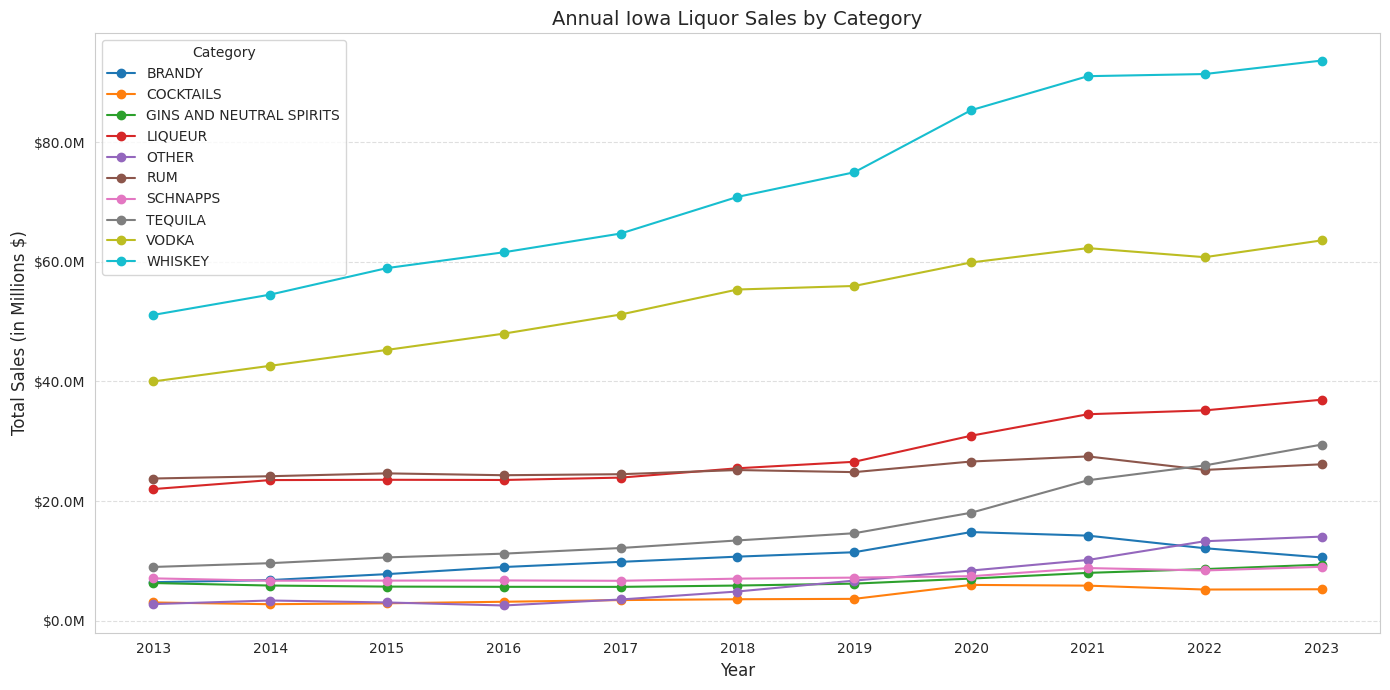

In [24]:
from matplotlib.ticker import FuncFormatter

# seaborn style for better aesthetics
sns.set_style("whitegrid")

# group by 'year' and 'category_new', then sum the 'sale_(dollars)' column
sales_by_category_year = df.groupby(['year', 'category_new'])['sale_(dollars)_cost'].sum().reset_index()

# pivot the table to have 'category_new' as columns
sales_pivot = sales_by_category_year.pivot(index='year', columns='category_new', values='sale_(dollars)_cost')

# define a color palette - can be replaced with a specific list of colors if desired
palette = sns.color_palette("tab10", len(sales_pivot.columns))

# plotting
ax = sales_pivot.plot(kind='line', marker='o', figsize=(14, 7), color=palette)

# set x-axis tick positions and labels
all_years = range(2013, 2024)
ax.set_xticks(all_years)
ax.set_xticklabels(all_years)

# format y-axis ticks to display in millions and improve readability
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '${:.1f}M'.format(x / 1e6)))

# improve the title and axis labels for clarity
plt.title('Annual Iowa Liquor Sales by Category', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Total Sales (in Millions $)', fontsize=12)
plt.legend(title='Category')

# Mmake the grid less pronounced
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.xaxis.grid(False)

# optimize spacing
plt.tight_layout()

# show the plot
plt.show()

# 3. TEQUILA ANALYSIS

## A. Selecting Tequila Data

In [25]:
# filter the DataFrame to include only rows with 'TEQUILA' in the 'category_new' column
tequila_df = df[df['category_new'] == 'TEQUILA']
tequila_df.head()

,date,store_name,address,city,zip_code,county,category,category_name,vendor_name,item_number,item_description,bottle_volume_(ml),state_bottle_cost,state_bottle_retail,bottles_sold,sale_(dollars),volume_sold_(liters),year,category_new,sale_(dollars)_cost
19,2022-10-24,WESTSIDE SPIRITS / CEDAR RAPIDS,3330 16TH AVE. SW,CEDAR RAPIDS,52404.0,LINN,1022100.0,MIXTO TEQUILA,PROXIMO,89198,JOSE CUERVO ESPECIAL REPOSADO,1750,22.50,33.75,1,33.75,1.75,2022,TEQUILA,22.50
28,2022-10-24,WESTSIDE SPIRITS / CEDAR RAPIDS,3330 16TH AVE. SW,CEDAR RAPIDS,52404.0,LINN,1022200.0,100% AGAVE TEQUILA,DIAGEO AMERICAS,88427,DELEON REPOSADO,750,22.49,33.74,1,33.74,0.75,2022,TEQUILA,22.49
69,2022-10-21,KUM & GO #509 / MARION,1203 BLAIRS FERRY RD,MARION,52302.0,LINN,1022200.0,100% AGAVE TEQUILA,"MAST-JAGERMEISTER US, INC",88372,TEREMANA REPOSADO TEQUILA,750,17.40,26.10,3,78.30,2.25,2022,TEQUILA,52.20
82,2022-10-24,PIT STOP LIQUORS / NEWTON,"1324, 1ST AVE E",NEWTON,50208.0,JASPER,1022200.0,100% AGAVE TEQUILA,PROXIMO,87832,JOSE CUERVO TRADICIONAL CRISTALINO,750,17.33,26.00,6,156.00,4.50,2022,TEQUILA,103.98
105,2022-10-24,WEST SIDE GROCERY,1802 WEST 7TH STREET,DAVENPORT,52802.0,SCOTT,1022200.0,100% AGAVE TEQUILA,PROXIMO,64933,1800 COCONUT,750,16.50,24.75,12,297.00,9.00,2022,TEQUILA,198.00


In [26]:
# checking shape of tequila_df
tequila_df.shape

(1358842, 20)

In [27]:
# saving tequila dataset
tequila_df.to_csv('/content/drive/MyDrive/iowa_tequila_sales.csv', index=False)

## B. Cleaning Tequila Dataset

In [28]:
# importing tequila data
tequila_df = pd.read_csv('/content/drive/MyDrive/iowa_tequila_sales.csv')
tequila_df.head()

,date,store_name,address,city,zip_code,county,category,category_name,vendor_name,item_number,item_description,bottle_volume_(ml),state_bottle_cost,state_bottle_retail,bottles_sold,sale_(dollars),volume_sold_(liters),year,category_new,sale_(dollars)_cost
0,2022-10-24,WESTSIDE SPIRITS / CEDAR RAPIDS,3330 16TH AVE. SW,CEDAR RAPIDS,52404.0,LINN,1022100.0,MIXTO TEQUILA,PROXIMO,89198,JOSE CUERVO ESPECIAL REPOSADO,1750,22.50,33.75,1,33.75,1.75,2022,TEQUILA,22.50
1,2022-10-24,WESTSIDE SPIRITS / CEDAR RAPIDS,3330 16TH AVE. SW,CEDAR RAPIDS,52404.0,LINN,1022200.0,100% AGAVE TEQUILA,DIAGEO AMERICAS,88427,DELEON REPOSADO,750,22.49,33.74,1,33.74,0.75,2022,TEQUILA,22.49
2,2022-10-21,KUM & GO #509 / MARION,1203 BLAIRS FERRY RD,MARION,52302.0,LINN,1022200.0,100% AGAVE TEQUILA,"MAST-JAGERMEISTER US, INC",88372,TEREMANA REPOSADO TEQUILA,750,17.40,26.10,3,78.30,2.25,2022,TEQUILA,52.20
3,2022-10-24,PIT STOP LIQUORS / NEWTON,"1324, 1ST AVE E",NEWTON,50208.0,JASPER,1022200.0,100% AGAVE TEQUILA,PROXIMO,87832,JOSE CUERVO TRADICIONAL CRISTALINO,750,17.33,26.00,6,156.00,4.50,2022,TEQUILA,103.98
4,2022-10-24,WEST SIDE GROCERY,1802 WEST 7TH STREET,DAVENPORT,52802.0,SCOTT,1022200.0,100% AGAVE TEQUILA,PROXIMO,64933,1800 COCONUT,750,16.50,24.75,12,297.00,9.00,2022,TEQUILA,198.00


In [29]:
# count unique item descriptions
item_description_count = tequila_df['item_description'].nunique()
print("Count of unique item descriptions:")
print(item_description_count)

Count of unique item descriptions:
885


In [30]:
# group by year and count unique item descriptions
item_description_count_per_year = tequila_df.groupby('year')['item_description'].nunique()

print("Count of unique item descriptions per year:")
print(item_description_count_per_year)

Count of unique item descriptions per year:
year
2013    165
2014    171
2015    152
2016    180
2017    210
2018    227
2019    258
2020    251
2021    319
2022    363
2023    483
Name: item_description, dtype: int64


The total number of unique item desciptions in the tequila dataset is 885 but there are only 483 in 2023, this implies that a lot of these items no longer exist or the item description has been changed over the years.

In [31]:
# get unique item descriptions
unique_descriptions = sorted(tequila_df['item_description'].unique())

# print the list of unique item descriptions
print("List of unique item descriptions in alphabetical order:")
for description in unique_descriptions:
    print(description)

List of unique item descriptions in alphabetical order:
"JOSE CUERVO SILVER ""ROLLING STONES"""
100 ANOS ANEJO
100 ANOS AZUL 100% AGAVE
1800 ANEJO
1800 ANEJO TEQUILA
1800 COCONUT
1800 COCONUT TEQUILA
1800 CRISTALINO
1800 CUCUMBER & JALAPENO
1800 REPOSADO
1800 REPOSADO TEQUILA
1800 REPOSADO TEQUILA WITH CLAY CUP
1800 SILVER
1800 SILVER MINI
1800 SILVER TEQUILA
1800 SILVER W/2 METAL COASTERS
1800 TEQUILA REPOSADO
1921 ANEJO
1921 TEQUILA ANEJO
1921 TEQUILA BLANCO
1921 TEQUILA REPOSADO
21SEEDS CUCUMBER JALAPENO TEQUILA
21SEEDS GRAPEFRUIT HIBISCUS
21SEEDS VALENCIA ORANGE TEQUILA
4 COPAS BLANCO USDA ORGANIC AND KOSHER CERTIFIED
4 COPAS TEQUILA ANEJO - USDA ORGANIC AND KOSHER CERTIFIED
400 CONEJOS MEZCAL
818 ANEJO TEQUILA
818 BLANCO TEQUILA
818 REPOSADO TEQUILA
901 TEQUILA HA
ADICTIVO ANEJO BLACK
ADICTIVO ANEJO BLACK TEQUILA
ADICTIVO ANEJO TEQUILA
ADICTIVO EXTRA ANEJO
ADICTIVO EXTRA ANEJO BLACK
ADICTIVO EXTRA ANEJO TEQUILA
ADICTIVO PLATA
ADICTIVO PLATA TEQUILA
ADICTIVO REPOSADO
ADICTIVO REPOS

To simplify the above list of item descriptions we will create a new column called "brand" and group the item descriptions by their corresponding brand. But first we will normalise the item description column to account for the special characters present in some names (e.g. special characters, like "Ñ" in "AÑEJO")

In [32]:
import unicodedata

def normalize_text(input_text):
    normalized = unicodedata.normalize('NFD', input_text)
    encoded = normalized.encode('ascii', 'ignore')
    return encoded.decode('ascii')

# overwrite the 'item_description' column with normalized text
tequila_df['item_description'] = tequila_df['item_description'].apply(normalize_text)

In [33]:
tequila_mapping = {
 '100 ANOS': ['100 ANOS ANEJO', '100 ANOS AZUL 100% AGAVE'],
 '1800': ['1800 ANEJO',
          '1800 ANEJO TEQUILA',
          '1800 COCONUT',
          '1800 COCONUT TEQUILA',
          '1800 CRISTALINO',
          '1800 CUCUMBER & JALAPENO',
          '1800 REPOSADO',
          '1800 REPOSADO TEQUILA',
          '1800 REPOSADO TEQUILA WITH CLAY CUP',
          '1800 SILVER',
          '1800 SILVER MINI',
          '1800 SILVER TEQUILA',
          '1800 SILVER W/2 METAL COASTERS',
          '1800 TEQUILA REPOSADO'],
 '1921': ['1921 ANEJO',
          '1921 TEQUILA ANEJO',
          '1921 TEQUILA BLANCO',
          '1921 TEQUILA REPOSADO'],
 '21SEEDS': ['21SEEDS CUCUMBER JALAPENO TEQUILA',
             '21SEEDS GRAPEFRUIT HIBISCUS',
             '21SEEDS VALENCIA ORANGE TEQUILA'],
 '4 COPAS': ['4 COPAS BLANCO USDA ORGANIC AND KOSHER CERTIFIED',
             '4 COPAS TEQUILA ANEJO - USDA ORGANIC AND KOSHER CERTIFIED'],
 '400 CONEJOS': ['400 CONEJOS MEZCAL', 'SOOH 400 CONEJOS MEZCAL'],
 '818': ['818 ANEJO TEQUILA',
         '818 BLANCO TEQUILA',
         '818 REPOSADO TEQUILA',
         'EIGHT RESERVE BY 818 TEQUILA'],
 '901 TEQUILA': ['901 TEQUILA HA'],
 'ADICTIVO': ['ADICTIVO ANEJO BLACK',
              'ADICTIVO ANEJO BLACK TEQUILA',
              'ADICTIVO ANEJO TEQUILA',
              'ADICTIVO EXTRA ANEJO',
              'ADICTIVO EXTRA ANEJO BLACK',
              'ADICTIVO EXTRA ANEJO TEQUILA',
              'ADICTIVO PLATA',
              'ADICTIVO PLATA TEQUILA',
              'ADICTIVO REPOSADO',
              'ADICTIVO REPOSADO CRISTALINO',
              'ADICTIVO REPOSADO TEQUILA',
              'ADICTIVO TEQUILA EXTRA ANEJO CRISTALINO',
              'ADICTIVO TEQUILA EXTRA ANEJO CRISTALINO DISCO',
              'SOOH ADICTIVO ANEJO',
              'SOOH ADICTIVO ANEJO TEQUILA'],
 'AGAVE LOCO': ['AGAVE LOCO'],
 'ALIPUS': ['ALIPUS SAN ANDREAS ENSAMBLE MEZCAL',
            'ALIPUS SAN JUAN MEZCAL',
            'ALIPUS SAN MIGUEL FELIX MEZCAL',
            'ALIPUS SANTA ANA DEL RIO MEZCAL'],
 'ALQUIMIA': ['ALQUIMIA EXTRA ANEJO VI TEQUILA',
              'ALQUIMIA EXTRA ANEJO XIV CASK STRENGTH TEQUILA',
              'ALQUIMIA TEQUILA ANEJO'],
 'AMAN': ['HA AMAN TEQUILA EL PROFESOR ANEJO', 'AMAN TEQUILA REPOSADO',
          'AMAN TEQUILA ROSA BLANCO', 'AMAN TEQUILA BLANCO', 'HA  AMAN TEQUILA EL PROFESOR ANEJO'],
 'AMARAS': ['AMARAS CUPREATA JOVEN MEZCAL',
            'AMARAS LOGIA CENIZO MEZCAL',
            'AMARAS LOGIA SIERRA NEGRA MEZCAL'],
 'AMOR': ['AMOR EXTRA ANEJO',
          'AMOR MIO EXTRA ANEJO',
          'AMOR REPOSADO',
          'AMOR SILVER'],
 'ANTIGUO': ['ANTIGUO ANEJO', 'ANTIGUO REPOSADO'],
 'ARETTE': ['ARETTE ARTESANAL SUAVE ANEJO TEQUILA',
            'ARETTE ARTESANAL SUAVE REPOSADO',
            'ARETTE GRAN CLASE EXTRA ANEJO',
            'ARETTE SUAVE BLANCO TEQUILA',
            'ARETTE SUAVE FUERTE BLANCO TEQUILA'],
 'ARTENOM': ['ARTENOM 1123 BLANCO HISTORICO TEQUILA',
             'ARTENOM 1146 ANEJO TEQUILA',
             'ARTENOM 1414 REPOSADO TEQUILA',
             'ARTENOM 1580 BLANCO',
             'ARTENOM SELECCION DE 1579 BLANCO'
             'TEQUILA ARTENOM SELECCION 1146 ANEJO',
             'ARTENOM SELECCION DE 1579 BLANCO',
             'TEQUILA ARTENOM SELECCION 1146 ANEJO'
],
 'ASOMBROSO': ['ASOMBROSO EROS REPOSADO TEQUILA',
               'ASOMBROSO GRAN RESERVA EXTRA ANEJO',
               'ASOMBROSO LA ROSA REPOSADO',
               'ASOMBROSO SILVER TEQUILA'],
 'ASTRAL': ['ASTRAL TEQUILA'],
 'AVION': ['AVION ANEJO',
           'AVION CRISTALINO',
           'AVION EXTRA ANEJO',
           'AVION REPOSADO',
           'AVION RESERVA 44',
           'AVION RESERVA 44 EXTRA ANEJO',
           'AVION SILVER',
           'AVION SILVER MINI'],
 'AZTECA AZUL': ['AZTECA AZUL PLATA',
                 'AZTECA AZUL PLATA TEQUILA',
                 'AZTECA AZUL REPOSADO',
                 'AZTECA AZUL REPOSADO TEQUILA'],
 'AZUNIA': ['AZUNIA ANEJO',
            'AZUNIA BLANCO',
            'AZUNIA PLATINUM(WHITE)',
            'AZUNIA REPOSADO'],
 'BALUARTE': ['BALUARTE ANEJO TEQUILA',
              'BALUARTE BLANCO TEQUILA',
              'BALUARTE REPOSADO TEQUILA'],
 'BANHEZ': ['BANHEZ MEZCAL',
            'BANHEZ MEZCAL - USE CODE 988511',
            'BANHEZ MEZCAL JOVEN',
            'BANHEZ PECHUGA MEZCAL'],
 'BLUE NECTAR': ["BLUE NECTAR ANEJO FOUNDER'S BLEND"],
 'BOSSCAL': ['BOSSCAL JOVEN MEZCAL'],
 'BOZAL': ['BOZAL BARRIL MEZCAL RESERVA',
           'BOZAL BORREGO MEZCAL',
           'BOZAL CASTILLA RESERVA MEZCAL',
           'BOZAL CENIZO MEZCAL',
           'BOZAL CUISHE MEZCAL',
           'BOZAL ENSAMBLE MEZCAL',
           'BOZAL JABALI RESERVA MEZCAL',
           'BOZAL PECHUGA MEZCAL',
           'BOZAL TOBALA RESERVA MEZCAL',
           'BOZAL TOBASICHE MEZCAL'],
 'BRUSCO': ['BRUSCO ARESANAL MEZCAL'],
 'CABO WABO': ['CABO WABO ANEJO', 'CABO WABO BLANCO', 'CABO WABO REPOSADO'],
 'CABRITO': ['CABRITO BLANCO', 'CABRITO BLANCO TEQUILA', 'CABRITO REPOSADO'],
 'CALIROSA': ['CALIROSA ANEJO', 'CALIROSA ROSA BLANCO'],
 'CALLE 23': ['CALLE 23 BLANCO', 'CALLE AZUL DE AGAVE ANEJO'],
 'CAMPO BRAVO': ['CAMPO BRAVO PLATA TEQUILA',
                 'CAMPO BRAVO PLATA TEQUILA MINI',
                 'CAMPO BRAVO REPOSADO TEQUILA',
                 'CAMPO BRAVO REPOSADO TEQUILA MINI'],
 'CAMPOVASO': ['CAMPOVASO BLANCO TEQUILA'],
 'CANCION': ['CANCION ANEJO TEQUILA',
             'CANCION BLANCO TEQUILA',
             'CANCION REPOSADO TEQUILA'],
 'CANTERA NEGRA': ['HA CANTERA NEGRA TEQUILA ANEJO',
                   'HA CANTERA NEGRA TEQUILA EXTRA ANEJO',
                   'CANTERA NEGRA TEQUILA EXTRA ANEJO',
                   'CANTERA NEGRA TEQUILA ANEJO',
                   'CANTERA NEGRA TEQUILA REPOSADO', 'CANTERA NEGRA TEQUILA SILVER',
                   'CANTERA NEGRA TEQUILA EXTRA AEJO', 'CANTERA NEGRA TEQUILA AEJO',
                   'HA CANTERA NEGRA TEQUILA REPOSADO', 'HA CANTERA NEGRA TEQUILA AEJO',
                   'HA CANTERA NEGRA TEQUILA EXTRA AEJO', 'HA CANTERA NEGRA TEQUILA SILVER',
                   'CANTERA NEGRA REPOSADO', 'CANTERA NEGRA ANEJO'],
 'CASA AMOR': ['CASA AMOR ANEJO',
               'CASA AMOR BLANCO',
               'CASA AMOR EXTRA ANEJO',
               'CASA AMOR REPOSADO'],
 'CASA DEL SOL': ['CASA DEL SOL REPOSADO'],
 'CASA DRAGONES': ['CASA DRAGONES ANEJO',
                   'CASA DRAGONES BLANCO',
                   'CASA DRAGONES JOVEN SIPPING TEQUILA'],
 'CASA MEXICO': ['CASA MEXICO EL GRAN JUBLIEO BLANCO TEQUILA'],
 'CASA NOBLE': ['CASA NOBLE ANEJO',
                'CASA NOBLE CRYSTAL',
                'CASA NOBLE CRYSTAL JOVAN SINGLE BARREL',
                'CASA NOBLE CRYSTAL JOVAN SINGLE BARREL TEQUILA',
                'CASA NOBLE CRYSTAL(BLANCO)',
                'CASA NOBLE REPOSADO'],
 'CASAMIGOS': ['CASAMIGOS ANEJO',
               'CASAMIGOS ANEJO MINI',
               'CASAMIGOS ANEJO W/ 4 COASTERS',
               'CASAMIGOS BLANCO',
               'CASAMIGOS BLANCO MINI',
               'CASAMIGOS BLANCO W/ 4 COASTERS',
               'CASAMIGOS BLANCO W/4 COASTERS',
               'CASAMIGOS CRISTALINO',
               'CASAMIGOS MEZCAL',
               'CASAMIGOS MEZCAL JOVEN',
               'CASAMIGOS MEZCAL W/ 4 COASTERS',
               'CASAMIGOS REPOSADO',
               'CASAMIGOS REPOSADO MINI',
               'CASAMIGOS REPOSADO W/ 4 COASTERS'],
 'CAZADORES': ['CAZADORES ANEJO',
               'CAZADORES ANEJO CRISTALINO',
               'CAZADORES BLANCO',
               'CAZADORES REPOSADO',
               'CAZADORES REPOSADO RESERVADO BUY THE BARREL',
               'CAZADORES TEQUILA BLANCO'],
 'CAZCANES': ['CAZCANES ANEJO TEQUILA NO 7',
              'CAZCANES BLANCO TEQUILA NO 9',
              'CAZCANES BLANCO TEQUILA NO. 7',
              'CAZCANES BLANCO TEQUILA NO.10 STILL STRENGTH',
              'CAZCANES REPOSADO TEQUILA NO 7'],
 'CENTINELA': ['CENTINELA ANEJO TEQUILA',
               'CENTINELA BLANCO TEQUILA',
               'CENTINELA REPOSADO TEQUILA'],
 'CHAMUCOS': ['CHAMUCOS BLANCO',
              'CHAMUCOS DIABLO BLANCO',
              'CHAMUCOS REPOSADO',
              'CHAMUCOS TEQUILA ANEJO',
              'CHAMUCOS TEQUILA BLANCO',
              'CHAMUCOS TEQUILA REPOSADO'],
 'CHAVO MALO': ['CHAVO MALO TEQUILA BLANCO'],
 'CHINACO': ['CHINACO ANEJO TEQUILA',
             'CHINACO BLANCO ARTISAN TEQUILA',
             'CHINACO REPOSADO TEQUILA'],
 'CHULA PARRANDA': ['CHULA PARRANDA REPOSADO',
                    'CHULA PARRANDA BLANCO',
                    'CHULA PARRANDA ANEJO',
                    'CHULA PARRANDA EXTRA ANEJO'],
 'CINCORO': ['CINCORO REPOSADO TEQUILA',
             'CINCORO BLANCO TEQUILA',
             'CINCORO ANEJO TEQUILA'],
 'CLASE AZUL': ['CLASE AZUL ANEJO',
                'CLASE AZUL DURANGO MEZCAL JOVEN',
                'CLASE AZUL PLATA',
                'CLASE AZUL REPOSADO',
                'HA CLASE AZUL GOLD TEQUILA',
                'AZUL SILVER',
                'AZUL REPOSADO'],
 'CODIGO 1530': ['CODIGO 1530 MEZCAL ARTESANAL JOVEN',
                 'CODIGO 1530 TEQUILA ANEJO',
                 'CODIGO 1530 TEQUILA ANEJO BUY THE BARREL',
                 'CODIGO 1530 TEQUILA ANEJO GEORGE STRAIT GOLD EDITION',
                 'CODIGO 1530 TEQUILA ANEJO MINI',
                 'CODIGO 1530 TEQUILA ANEJO PLAYBOY SPIRITS RARE W/2 GLASSES',
                 'CODIGO 1530 TEQUILA BLANCO',
                 'CODIGO 1530 TEQUILA BLANCO MINI',
                 'CODIGO 1530 TEQUILA ORIGEN (EXTRA ANEJO)',
                 'CODIGO 1530 TEQUILA ORIGEN EXTRA ANEJO GEORGE STRAIT LIMITED',
                 'CODIGO 1530 TEQUILA REPOSADO',
                 'CODIGO 1530 TEQUILA REPOSADO MINI',
                 'CODIGO 1530 TEQUILA ROSA BLANCO',
                 'CODIGO 1530 TEQUILA ROSA SINGLE BARREL BUY THE BARREL',
                 'HA CODIGO 1530 TEQUILA EXTRA ANEJO 14 YEARS W/ 2 GLASSES',
                 'HA CODIGO 1530 GEORGE STRAIT ROSA REPOSADO',
                 'HA CODIGO 1530 PLAYBOY 2ND EDITION ANEJO',
                 'HA CODIGO 1530 MEZCAL ANCESTRAL JOVEN',
                 'SOOH CODIGO 1530 TEQUILA ANEJO'],
 'COMISARIO': ['COMISARIO ANEJO TEQUILA',
               'COMISARIO BLANCO TEQUILA',
               'COMISARIO REPOSADO TEQUILA',
               'TEQUILA COMISARIO ANEJO',
               'TEQUILA COMISARIO BLANCO',
               'TEQUILA COMISARIO REPOSADO'],
 'COMPOVEDA': ['COMPOVEDA TEQUILA EXTRA ANEJO', 'COMPOVEDA TEQUILA REPOSADO',],
 'CONCIERE': ['CONCIERE SILVER TEQUILA',
              'CONCIERE GOLD TEQUILA',
              'CONCIERE TEQUILA SILVER',
              'CONCIERE TEQUILA GOLD'],
 'CONVITE': ['CONVITE ESENCIAL ESPADIN MEZCAL'],
 'CORAZON': ['CORAZON ANEJO',
             'CORAZON ANEJO BUY THE BARREL',
             'CORAZON ANEJO TEQUILA',
             'CORAZON ANEJO TEQUILA BUY THE BARREL',
             'CORAZON BLANCO TEQUILA',
             'CORAZON DE AGAVE ANEJO TEQUILA',
             'CORAZON DE AGAVE BLANCO',
             'CORAZON DE AGAVE REPOSADO',
             'CORAZON DE AGAVE REPOSADO TEQUILA',
             'CORAZON DE AGAVE TEQUILA BLANCO',
             'CORAZON REPOSADO',
             'CORAZON REPOSADO BUY THE BARREL',
             'CORAZON TEQUILA BLANCO'],
 'CORRALEJO': ['HA CORRALEJO 1821 ANEJO TEQUILA',
               'HA CORRALEJO 1821 EXTRA ANEJO',
               'CORRALEJO ANEJO', 'CORRALEJO REPOSADO', 'CORRALEJO SILVER',
               'CORRALEJO EXTRA ANEJO', 'CORRALEJO REPOSADO TEQUILA',
               'CORRALEJO ANEJO TEQUILA', 'CORRALEJO GRAN ANEJO',
               'CORRALEJO REPOSADO TEUQILA', 'CORRALEJO BLANCO TEQUILA',
               'CORRALEJO REPOSADO W/2 ROCKS GLASSES'],
 'CREYENTE': ['CREYENTE MEZCAL'],
 'CRUZ DEL SOL': ['CRUZ DEL SOL REPOSADO', 'CRUZ DEL SOL SILVER'],
 'CUTWATER': ['CUTWATER REPOSADO TEQUILA',
              'CUTWATER TEQUILA ANEJO',
              'CUTWATER TEQUILA BLANCO',
              'CUTWATER TEQUILA REPOSADO'],
 'DAHLIA': ['DAHLIA CRISTALINO TEQUILA'],
 'DEL MAGUEY': ['DEL MAGUEY ARROQUENO',
                'DEL MAGUEY CREMA DE MEZCAL',
                'DEL MAGUEY ESPADIN ESPECIAL',
                'DEL MAGUEY JABALI',
                'DEL MAGUEY LAS MILPAS',
                'DEL MAGUEY MEZCAL VIDA',
                'DEL MAGUEY MINERO',
                'DEL MAGUEY PUEBLA',
                'DEL MAGUEY SAN JOSE RIO MINAS',
                'DEL MAGUEY SAN LUIS DEL RIO',
                'DEL MAGUEY TOBALA',
                'DEL MAGUEY VIDA DE MUERTOS',
                'DEL MAGUEY VIDA MEZCAL',
                'DEL MAGUY CREMA DE MEZCAL',
                'DEL MAGUEY WILD PAPALOME'],
 'DELEON': ['DELEON LEONA', 'DELEON PLATINUM', 'DELEON REPOSADO'],
 'DERRUMBES': ['DERRUMBES MICHOACAN'],
 'DINASTIA REAL': ['DINASTIA REAL ANEJO CRANEO',
                   'DINASTIA REAL EXTRA AGED MUERTOS',
                   'DINASTIA REAL EXTRA ANEJO YR'],
 'DON AMADO': ['DON AMADO MEZCAL ANEJO'],
 'DON EDUARDO': ['DON EDUARDO ANEJO TEQUILA',
                 'DON EDUARDO REPOSADO',
                 'DON EDUARDO SILVER TEQUILA'],
 'DON FULANO': ['DON FULANO ANEJO TEQUILA',
                'DON FULANO BLANCO TEQUILA',
                'DON FULANO IMPERIAL EXTRA ANEJO TEQUILA',
                'DON FULANO REPOSADO TEQUILA'],
 'DON JULIO': ['DON JULIO 1942',
               'DON JULIO 70TH ANNIVERSARY',
               'DON JULIO ANEJO',
               'DON JULIO ANEJO MINI',
               'DON JULIO ANEJO TEQUILA',
               'DON JULIO BLANCO',
               'DON JULIO BLANCO MINI',
               'DON JULIO BLANCO TEQUILA',
               'DON JULIO BLANCO USE CODE 87483',
               'DON JULIO REAL',
               'DON JULIO REPOSADO',
               'DON JULIO REPOSADO PRIMAVERA',
               'DON JULIO REPOSADO PRIVATE CASK BUY THE BARREL',
               'DON JULIO REPOSADO W/2 GLASSES',
               'DON JULIO ROSADO'],
 'DON NACHO': ['DON NACHO BLANCO',
               'DON NACHO BLANCO TEQUILA',
               'DON NACHO EXTRA PREMIUM ANEJO',
               'DON NACHO EXTRA PREMIUM ANEJO TEQUILA',
               'DON NACHO EXTRA PREMIUM BLANCO',
               'DON NACHO EXTRA PREMIUM BLANCO TEQUILA',
               'DON NACHO EXTRA PREMIUM REPOSADO',
               'DON NACHO EXTRA PREMIUM REPOSADO TEQUILA',
               'DON NACHO REPOSADO',
               'DON NACHO REPOSADO TEQUILA'],
 'DON RAMON': ['DON RAMON TEQUILA ANEJO',
               'DON RAMON TEQUILA REPOSADO',
               'DON RAMON TEQUILA RESERVA REPOSADO',
               'DON RAMON TEQUILA SILVER',
               'TEQUILA DON RAMON ANEJO', 'DON RAMON TEQUILA ANEJO',
               'DON RAMON TEQUILA AEJO', 'TEQUILA DON RAMON AEJO'],
 'DORADO': ['DORADO GOLD TEQUILA'],
 'DOS HOMBRES': ['DOS HOMBRES MEZCAL'],
 'DOS PRIMOS': ['DOS PRIMOS ANEJO TEQUILA',
                'DOS PRIMOS BLANCO',
                'DOS PRIMOS REPOSADO'],
 'DUKE': ['DUKE EXTRA ANEJO', 'DUKE REPOSADO'],
 'DULCE VIDA': ['DULCE VIDA BLANCO',
                'DULCE VIDA EXTRA ANEJO',
                'DULCE VIDA GRAPEFRUIT',
                'DULCE VIDA LIME',
                'DULCE VIDA PINEAPPLE JALAPENO',
                'DULCE VIDA TEQUILA LIME',
                'DULCE VIDA TEQUILA PINEAPPLE JALAPENO',
                'SOOH DULCE VIDA BLANCO 100PRF',
                'SOOH DULCE VIDA ORGANIC BLANCO TEQUILA'],
 'EL CHARRO': ['EL CHARRO REPOSADO'],
 'EL CONQUISTADOR': ['EL CONQUISTADOR ANEJO TEQUILA',
                     'EL CONQUISTADOR BLANCO TEQUILA DNO'],
 'EL JIMADOR': ['EL JIMADOR ANEJO',
                'EL JIMADOR ANEJO TEQUILA',
                'EL JIMADOR REPOSADO',
                'EL JIMADOR REPOSADO MINI',
                'EL JIMADOR REPOSADO TEQUILA',
                'EL JIMADOR REPOSADO TEQUILA MINI',
                'EL JIMADOR SILVER',
                'EL JIMADOR SILVER TEQUILA'],
 'EL MAYOR': ['EL MAYOR ANEJO',
              'EL MAYOR ANEJO BARREL PROGRAM',
              'EL MAYOR ANEJO MASTERS COLLECTION-BUY THE BARREL',
              'EL MAYOR ANEJO TEQUILA',
              'EL MAYOR BLANCO',
              'EL MAYOR EXTRA ANEJO 100% AGAVE HA',
              'EL MAYOR REPOSADO',
              'EL MAYOR REPOSADO BARREL PROGRAM',
              'SOOH EL MAYOR CRISTALINO',
              'HA EL MAYOR CASK FINISH 100% AGAVE TEQUILA',
              'HA EL MAYOR SINGLE ESTATE 100% AGAVE TEQUILA',
              'HA EL MAYOR EXTRA ANEJO 25TH ANNIVERSARY BOURBON BARREL AGED'],
 'EL NIVEL': ['EL NIVEL ANEJO',
              'EL NIVEL BLANCO',
              'EL NIVEL TEQUILA BLANCO',
              'EL NIVEL TEQUILA REPOSADO'],
 'EL SILENCIO': ['EL SILENCIO MEZCAL ESPADIN'],
 'EL TESORO': ['EL TESORO ANEJO',
               'EL TESORO ANEJO TEQUILA',
               'EL TESORO BLANCO',
               'EL TESORO GOLD (REPOSADO) TEQUILA',
               'EL TESORO PARADISO ANEJO',
               'EL TESORO PLATINUM',
               'EL TESORO PLATINUM TEQUILA',
               'EL TESORO REPOSADO',
               'SOOH EL TESORO ANEJO'],
 'EL TORO': ['EL TORO REPOSADO TEQUILA'],
 'EL TRAGO': ['EL TRAGO BLANCO'],
 'EL ZARCO': ['EL ZARCO GOLD',
              'EL ZARCO GOLD TEQUILA',
              'EL ZARCO SILVER',
              'EL ZARCO SILVER DISCO'],
 'ELVELO': ['ELVELO BLANCO TEQUILA'],
 'ESPOLON': ['ESPOLON ANEJO',
             'ESPOLON BLANCO',
             'ESPOLON REPOSADO',
             'ESPOLON TEQUILA BLANCO',
             'ESPOLON TEQUILA REPOSADO'],
 'EXOTICO': ['EXOTICO BLANCO',
             'EXOTICO BLANCO 100% AGAVE TEQUILA',
             'EXOTICO REPOSADO',
             'EXOTICO REPOSADO 100% AGAVE TEQUILA'],
 'EXPRESIONES CORAZON': ['HA EXPRESIONES CORAZON ANJEO ORVW FINISH',
                         'HA EXPRESIONES CORAZON BLANCO',
                         'HA EXPRESIONES CORAZON REPO BUFFALO TRACE FINISHED'],
 'FAMILIA CAMARENA': ['FAMILIA CAMARENA ANEJO',
                      'FAMILIA CAMARENA REPOSADO',
                      'FAMILIA CAMARENA SILVER'],
 'FLECHA AZUL': ['FLECHA AZUL ANEJO',
                 'FLECHA AZUL BLANCO',
                 'FLECHA AZUL CRISTALINO',
                 'FLECHA AZUL REPOSADO'],
 'FLOR AZUL': ['FLOR AZUL REPOSADO', 'FLOR AZUL SILVER TEQUILA'],
 'FORTALEZA': ['FORTALEZA TEQUILA BLANCO', 'FORTALEZA TEQUILA REPOSADO'],
 'FRIDA KAHLO': ['FRIDA KAHLO ANEJO TEQUILA', 'FRIDA KAHLO BLANCO TEQUILA'],
 'GAS MONKEY': ['GAS MONKEY CINNAMON TEQUILA'],
 'GHOST': ['GHOST TEQUILA', 'GHOST TEQUILA BLANCO'],
 'GIRO': ['GIRO GOLD'],
 'GRACIAS A DIOS': ['GRACIAS A DIOS MEZCAL ARROQUENO',
                    'GRACIAS A DIOS MEZCAL CUPREATA',
                    'GRACIAS A DIOS MEZCAL ESPADIN',
                    'GRACIAS A DIOS MEZCAL ESPADIN REPOSADO',
                    'GRACIAS A DIOS MEZCAL MANGO',
                    'GRACIAS A DIOS MEZCAL MEXICANO',
                    'GRACIAS A DIOS MEZCAL PECHUGA',
                    'GRACIAS A DIOS MEZCAL PINA',
                    'GRACIAS A DIOS MEZCAL TEPEXTATE',
                    'GRACIAS A DIOS MEZCAL TOBALA',
                    'GRACIAS A DIOS MEZCAL TOBALA CULTIVADO'],
 'GRAN CAVA DE ORO': ['GRAN CAVA DE ORO ANEJO',
                      'GRAN CAVA DE ORO EXTRA AGED ANEJO BLACK',
                      'GRAN CAVA DE ORO EXTRA ANEJO',
                      'GRAN CAVA DE ORO PLATA',
                      'GRAN CAVA DE ORO REPOSADO',
                      'SOOH GRAN CAVA DE ORO EXTRA ANEJO',
                      'GRAN CAVA DE ORO ANEJO',
                      'GRAN CAVA DE ORO  ANEJO'],
 'GRAN CENTENARIO': ['GRAN CENTENARIO ANEJO',
                     'GRAN CENTENARIO CRISTALINO',
                     'GRAN CENTENARIO LEYENDA ANEJO',
                     'GRAN CENTENARIO LEYENDA TEQUILA',
                     'GRAN CENTENARIO PLATA',
                     'GRAN CENTENARIO PLATA TEQUILA',
                     'GRAN CENTENARIO REPOSADO',
                     'GRAN CENTENARIO SILVER',
                     'SOOH GRAN CENTENARIO ANEJO',
                     'SOOH GRAN CENTENARIO REPOSADO'],
 'GRAN CORAMINO': ['GRAN CORAMINO ANEJO', 'GRAN CORAMINO REPOSADO CRISTALINO'],
 'GRAND MAYAN': ['GRAND MAYAN EXTRA ANEJO TEQUILA'],
 'HACIENDA VIEJA': ['HACIENDA VIEJA',
                    'HACIENDA VIEJA ANEJO',
                    'HACIENDA VIEJA BLANCO TEQUILA',
                    'HACIENDA VIEJA REPOSADO',
                    'HACIENDA VIEJA REPOSADO TEQUILA'],
 'HERRADURA': ['HERRADURA ANEJO',
               'HERRADURA ANEJO MINI',
               'HERRADURA ANJEO',
               'HERRADURA BLANCO SILVER 80 PRF TEQUILA',
               'HERRADURA GOLD REPOSADO 6PAK',
               'HERRADURA LEGEND',
               'HERRADURA LEGEND ANEJO',
               'HERRADURA REPOSADO',
               'HERRADURA SELECCION SUPREMA TEQUILA',
               'HERRADURA SELECTION SUPREMA',
               'HERRADURA SILVER',
               'HERRADURA SILVER MINI',
               'HERRADURA SLIVER',
               'HERRADURA ULTRA ANEJO'],
 'HONOR DEL CASTILLO': ['HONOR DEL CASTILLO AFILADO HIGH PROOF REPOSADO '
                        'TEQUILA',
                        'HONOR DEL CASTILLO REDENCION CLEAR REPOSADO TEQUILA',
                        'HONOR DEL CASTILLO REFLEXION BLANCO TEQUILA'],
 'HOOTERS': ['HOOTERS GOLD TEQUIA', 'HOOTERS SILVER TEQUILA'],
 'HORNITOS': ['HORNITOS ANEJO',
              'HORNITOS BLACK BARREL',
              'HORNITOS CRISTALINO',
              'HORNITOS GOLD',
              'HORNITOS LIME SHOT',
              'HORNITOS PLATA',
              'HORNITOS REPOSADO',
              'HORNITOS SPICED HONEY',
              'SAUZA HORNITOS ANEJO',
              'SAUZA HORNITOS REPOSADO'],
 'HOYO 19': ['HOYO 19 EXTRA ANEJO'],
 "HUSSONG'S": ["HUSSONG'S 100% SILVER TEQUILA",
               "HUSSONG'S PLATINUM ANEJO",
               "HUSSONG'S REPOSADO TEQUILA",
               "HUSSONG'S REPOSADO TEQUILA 100% AGAVE",
               'HUSSONGS ANEJO',
               'HUSSONGS PLATINUM ANEJO',
               'HUSSONGS REPOSADO',
               'HUSSONGS SILVER',
               'HUSSONGS SILVER TEQUILA'],
 'ILEGAL MEZCAL': ['ILEGAL MEZCAL ANEJO',
                   'ILEGAL MEZCAL JOVEN',
                   'ILEGAL MEZCAL REPOSADO'],
 'INFUSED TEQUILA': ['INFUSED TEQUILA JALAPENO LIME',
                     'INFUSED TEQUILA PINK LEMONADE'],
 'IXA': ['IXA TEQUILA'],
 'JAJA': ['JAJA BLANCO', 'JAJA BLANCO TEQUILA', 'JAJA REPOSADO'],
 'JOSE CUERVO': ['JOSE CUERVO SILVER ROLLING STONES',
                 'JOSE CUERVO BLACK MEDALLION',
                 'JOSE CUERVO CINGE',
                 'JOSE CUERVO CINGE MINI',
                 'JOSE CUERVO ESPECIAL GOLD MINI',
                 'JOSE CUERVO ESPECIAL REPOSADO',
                 'JOSE CUERVO ESPECIAL REPOSADO FLASK',
                 'JOSE CUERVO ESPECIAL REPOSADO MINI',
                 'JOSE CUERVO ESPECIAL REPOSADO SQUARE',
                 'JOSE CUERVO ESPECIAL REPOSADO TEQUILA',
                 'JOSE CUERVO ESPECIAL REPOSADO TEQUILA MINI',
                 'JOSE CUERVO ESPECIAL SILVER',
                 'JOSE CUERVO ESPECIAL SILVER FLASK',
                 'JOSE CUERVO ESPECIAL SILVER MINI',
                 'JOSE CUERVO ESPECIAL SILVER TEQUILA',
                 'JOSE CUERVO ESPECIAL SILVER TEQUILA MINI',
                 'JOSE CUERVO LA RESERVA DE LA FAMILIA',
                 'JOSE CUERVO PLATINO RESERVA DE LA FAMILIA',
                 'JOSE CUERVO RESERVA DE LA FAMILIA PLATINO',
                 'JOSE CUERVO RESERVA DE LA FAMILIA REPOSADO',
                 'JOSE CUERVO SILVER ROLLING STONES',
                 'JOSE CUERVO TRADICIONAL ANEJO',
                 'JOSE CUERVO TRADICIONAL CRISTALINO',
                 'JOSE CUERVO TRADICIONAL REPOSADO',
                 'JOSE CUERVO TRADICIONAL REPOSADO TEQUILA',
                 'JOSE CUERVO TRADICIONAL SILVER',
                 'SOOH JOSE CUERVO ESPECIAL GOLD FLASK',
                 'JOSE CUERVO SILVER "ROLLING STONES"',
                 '"JOSE CUERVO SILVER ""ROLLING STONES"""',
                 'JOSE CUERVO TRADICIONAL ANEJO',
                 'JOSE CUERVO TRADICIONAL AEJO'
],
 'JUAN IN A MILLION': ['JUAN IN A MILLION 116 MONTH EXTRA ANEJO'],
 'JUAREZ': ['JUAREZ GOLD',
            'JUAREZ SILVER',
            'JUAREZ TEQUILA GOLD',
            'JUAREZ TEQUILA SILVER',
            'JUAREZ GOLD TEQUILA'],
 'KAH': ['KAH ANEJO',
         'KAH BLANCO MINI',
         'KAH EXTRA ANEJO',
         'KAH REPOSADO',
         'KAH TEQUILA ANEJO',
         'KAH TEQUILA ANEJO MINI',
         'KAH TEQUILA BLANCO',
         'KAH TEQUILA BLANCO DISCO',
         'KAH TEQUILA BLANCO MINI',
         'KAH TEQUILA REPOSADO',
         'KAH TEQUILA REPOSADO MINI'],
 'KIRKLAND SIGNATURE': ['KIRKLAND SIGNATURE BLANCO TEQUILA',
                        'KIRKLAND SIGNATURE REPOSADO TEQUILA',
                        'KIRKLAND SIGNATURE TEQUILA ANEJO',
                        'KIRKLAND SIGNATURE TEQUILA SILVER'],
 'KOMOS': ['KOMOS ANEJO RESERVA',
           'TEQUILA KOMOS ANEJO CRISTALINO',
           'TEQUILA KOMOS EXTRA ANEJO',
           'TEQUILA KOMOS REPOSADO ROSA'],
 'LA ADELITA': ['LA ADELITA REPOSADO TEQUILA'],
 'LA GRITONA': ['LA GRITONA REPOSADO TEQUILA'],
 'LA LUNA': ['LA LUNA MEZCAL CUPREATA'],
 'LA PRIMA': ['LA PRIMA GOLD',
              'LA PRIMA TEQUILA/GOLD',
              'LA PRIMA TEQUILA/WHITE',
              'LA PRIMA WHITE'],
 'LA VENENOSA': ['LA VENENOSA RAICILLA TABERNAS'],
 'LAGRIMAS DE DOLORES': ['LAGRIMAS DE DOLORES ANEJO MEZCAL',
                         'LAGRIMAS DE DOLORES HACIENDA DOLORES CENIZO COLONIAL',
                         'LAGRIMAS DE DOLORES TEMOAYA CENIZO COLONIAL'],
 'LALO': ['LALO TEQUILA BLANCO'],
 'LIBELULA': ['LIBELULA TEQUILA'],
 'LOBOS 1707': ['LOBOS 1707 EXTRA ANEJO NECKTIE',
                'LOBOS 1707 JOVEN NECKTIE',
                'LOBOS 1707 MEZCAL NECKTIE',
                'LOBOS 1707 REPOSADO NECKTIE'],
 'LOS AMANTES': ['LOS AMANTES MEZCAL ANEJO TEQUILA', 'LOS AMANTES JOVEN', 'LOS AMANTES MEZCAL ANEJO TEQUILA',
                 'LOS AMANTES MEZCAL ANEJO  TEQUILA'],
 'LOS ARANGO': ['LOS ARANGO ANEJO', 'LOS ARANGO BLANCO', 'LOS ARANGO REPOSADO'],
 'LOS OSUNA': ['LOS OSUNA ANEJO', 'LOS OSUNA BLANCO', 'LOS OSUNA REPOSADO'],
 'LOS SIETE MISTERIOS': ['LOS SIETE MISTERIOS DOBA YEJ',
                         'LOS SIETE MISTERIOS DOBA YEJ MEZCAL',
                         'LOS SIETE MISTERIOS ENSAMBLE ESPADIN-MEXICANITO',
                         'LOS SIETE MISTERIOS ENSAMBLE ESPADIN-TEPEZTATE'],
 'LOS VECINOS': ['LOS VECINOS ESPADIN MEZCAL'],
 'LUNAZUL': ['LUNAZUL BLANCO',
             'LUNAZUL BLANCO MINI',
             'LUNAZUL BLANCO TEQUILA',
             'LUNAZUL REPOSADO',
             'LUNAZUL REPOSADO MINI',
             'LUNAZUL TEQUILA ANEJO',
             'LUNAZUL TEQUILA REPOSADO',
             'LUNAZUL BLANCO',
             'LUNAZUL REPOSADO',
             'LUNAZUL  BLANCO', 'LUNAZUL  REPOSADO'],
 'MAESTRO DOBEL': ['MAESTRO DOBEL',
                   'MAESTRO DOBEL 50 CRISTALINO',
                   'MAESTRO DOBEL ANEJO',
                   'MAESTRO DOBEL ANEJO AF4 BUY THE BARREL',
                   'MAESTRO DOBEL DIAMANTE TEQUILA',
                   'MAESTRO DOBEL REPOSADO',
                   'MAESTRO DOBEL REPOSADO TEQUILA',
                   'MAESTRO DOBEL SILVER',
                   'MAESTRO DOBEL SILVER TEQUILA',
                   'SOOH MAESTRO DOBEL 50 CRISTALINO'],
 'MARACAME': ['MARACAME PLATA TEQUILA', 'MARACAME REPOSADO'],
 'MARCA NEGRA': ['MARCA NEGRA ESPADIN', 'MARCA NEGRA TOBALA'],
 'MARGARITAVILLE': ['MARGARITAVILLE GOLD TEQUILA',
                    'MARGARITAVILLE GOLD TEQUILA MINI',
                    'MARGARITAVILLE SILVER TEQUILA',
                    'MARGARITAVILLE SILVER TEQUILA MINI'],
 'MAYALEN': ['MAYALEN MACHETAZO ESPADIN',
             'MAYALEN MACHETAZO SALMIANA',
             'MAYALEN MEZCAL MACHETAZO'],
 'MEMBERS MARK': ['MEMBERS MARK SILVER TEQUILA'],
 'MEZCAL AMARAS': ['MEZCAL AMARAS', 'MEZCAL AMARAS CUPREATA'],
 'MEZCAL SACRIFICIO': ['MEZCAL SACRIFICIO JOVEN', 'MEZCAL SACRIFICIO REPOSADO'],
 'MEZCAL VAGO': ['MEZCAL VAGO ELOTE'],
 'MIJENTA': ['MIJENTA TEQUILA BLANCO', 'MIJENTA TEQUILA REPOSADO'],
 'MILAGRO': ['MILAGRO ANEJO',
             'MILAGRO ANEJO TEQUILA',
             'MILAGRO REPOSADO',
             'MILAGRO REPOSADO TEQUILA',
             'MILAGRO SELECT BARREL ANEJO',
             'MILAGRO SELECT BARREL REPOSADO',
             'MILAGRO SELECT BARREL SILVER TEQUILA',
             'MILAGRO SILVER',
             'MILAGRO SILVER TEQUILA',
             'MILAGRO TEQUILA SBR SILVER'],
 'MONTE ALBAN': ['MONTE ALBAN MEZCAL',
                 'MONTE ALBAN REPOSADO',
                 'MONTE ALBAN REPOSADO TEQUILA',
                 'MONTE ALBAN SILVER',
                 'MONTE ALBAN SILVER TEQUILA'],
 'MONTELOBOS': ['MONTELOBOS',
                'MONTELOBOS ESPADIN MEZCAL',
                'MONTELOBOS ESPADIN MEZCAL',
                'MONTELOBOS PECHUGA MEZCAL',
                'MONTELOBOS TOBALA',
                'SOOH MONTELOBOS'],
 'MONTEZUMA': ['MONTEZUMA GOLD',
               'MONTEZUMA GOLD TEQUILA',
               'MONTEZUMA WHITE',
               'MONTEZUMA WHITE TEQUILA'],
 'MUCHA LIGA': ['MUCHA LIGA ANEJO TEQUILA',
                'MUCHA LIGA BLANCO TEQUILA',
                'MUCHA LIGA REPOSADO TEQUILA'],
 'NUESTRA SOLEDAD': ['NUESTRA SOLEDAD EJUTLA',
                     'NUESTRA SOLEDAD LACHIGUI MIAHUATLAN',
                     'NUESTRA SOLEDAD SAN BALTAZAR',
                     'NUESTRA SOLEDAD SAN LUIS DEL RIO MEZCAL',
                     'NUESTRA SOLEDAD SANTIAGO MATATLAN'],
 'NUEVEUNO': ['NUEVEUNO ANEJO ORGANIC',
              'NUEVEUNO BLANCO ORGANIC',
              'NUEVEUNO REPOSADO ORGANIC'],
 'NUMBER JUAN': ['NUMBER JUAN BLANCO',
                 'NUMBER JUAN EXTRA ANEJO',
                 'NUMBER JUAN REPOSADO',
                 'NUMBER JUAN TEQUILA BLANCO',
                 'NUMBER JUAN TEQUILA EXTRA ANEJO',
                 'NUMBER JUAN TEQUILA REPOSADO'],
 'OJO DE TIGRE': ['OJO DE TIGRE ARTESANAL MEZCAL'],
 'OLMECA': ['OLMECA PLATA', 'OLMECA REPOSADO'],
 'OLMECA ALTOS': ['OLMECA ALTOS PLATA',
                  'OLMECA ALTOS PLATA MINI',
                  'OLMECA ALTOS PLATA MINI DISCO',
                  'OLMECA ALTOS REPOSADO',
                  'OLMECA ALTOS REPOSADO MINI',
                  'ALTOS ANEJO'],
 'PADRECITO': ['PADRECITO'],
 'PARTIDA': ['PARTIDA ANEJO TEQUILA',
             'PARTIDA BLANCO TEQUILA',
             'PARTIDA ELEGANTE TEQUILA',
             'PARTIDA REPOSADO TEQUILA'],
 'PASOTE': ['PASOTE ANEJO TEQUILA',
            'PASOTE BLANCO TEQUILA',
            'PASOTE EXTRA ANEJO TEQUILA',
            'PASOTE REPOSADO TEQUILA'],
 'PATRON': ['PATRON ANEJO',
            'PATRON ANEJO 100ML',
            'PATRON ANEJO 200ML',
            'PATRON ANEJO MINI',
            'PATRON BARREL SELECT REPOSADO BARREL',
            'PATRON EL ALTO',
            'PATRON EL CIELO',
            'PATRON EXTRA ANEJO',
            'PATRON EXTRA ANEJO 10 ANOS',
            'PATRON GRAN BURDEOS',
            'PATRON GRAN PIEDRA',
            'PATRON GRAN PLATINUM',
            'PATRON GUILLERMO DEL TORO EXTRA ANEJO & ORANGE DISCO',
            'PATRON RAINBOW PACK',
            'PATRON REPOSADO',
            'PATRON REPOSADO 100ML',
            'PATRON REPOSADO 200ML',
            'PATRON REPOSADO BARREL SELECT',
            'PATRON REPOSADO BARREL SELECT PROGRAM',
            'PATRON REPOSADO MINI',
            'PATRON REPOSADO TEQUILA',
            'PATRON ROCA SILVER',
            'PATRON SILVER',
            'PATRON SILVER MINI',
            'PATRON SILVER SPECIAL EDITION',
            'PATRON SILVER TEQUILA',
            'PATRON TEQUILA SILVER',
            'PATRON TEQUILA SILVER MINI',
            'PATRON EXTRA ANEJO',
            'HA GRAN PATRON BURDEOS',
            'HA GRAN PATRON PIEDRAHA PATRON GUILLERMO DEL TORO EXTRA ANEJO & '
            'ORANGE',
            'HA PATRON ESTATE RELEASE',
            'SOOH PATRON EXTRA ANEJO 10 ANOS',
            'GRAN PATRON SMOKY',
            'PATRON EXTRA ANEJO',
            'HA GRAN PATRON PIEDRA',
            'PATRN EXTRA AEJO', 'HA PATRON GUILLERMO DEL TORO EXTRA ANEJO & ORANGE'],
 'PELIGROSO': ['PELIGROSO ANEJO',
               'PELIGROSO CINNAMON',
               'PELIGROSO CINNAMON MINI',
               'PELIGROSO REPOSADO',
               'PELIGROSO SILVER'],
 'PEPE LOPEZ': ['PEPE LOPEZ GOLD', 'PEPE LOPEZ GOLD TEQUILA'],
 'PROSPERO': ['PROSPERO BLANCO TEQUILA'],
 'PUEBLO VIEJO': ['PUEBLO VIEJO BLANCO TEQUILA'],
 'RANCHO LA GLORIA': ['RANCHO LA GLORIA ANEJO',
                      'RANCHO LA GLORIA BLANCO',
                      'RANCHO LA GLORIA REPOSADO'],
 'RANCHO TEPUA': ['RANCHO TEPUA BACANORA BLANCO'],
 'REVOLUCION': ['REVOLUCION SILVER'],
 'ROCK N ROLL': ['ROCK N ROLL TEQUILA GUITAR CRISTALINO ANEJO',
                         'ROCK N ROLL TEQUILA GUITAR CRISTALINO REPOSADO',
                         'ROCK N ROLL TEQUILA GUITAR MANGO',
                         'ROCK N ROLL TEQUILA GUITAR STRAWBERRY',
                         'ROCK N ROLL TEQUILA PLATINUM'],
 'ROGER CLYNES': ['ROGER CLYNES MEXICAN MOONSHINE ANEJO'],
 'SAN MATIAS': ['SAN MATIAS ANEJO 135YR',
                'SAN MATIAS GRAN RESERVA ANEJO',
                'SAN MATIAS GRAN RESERVA TEQUILA',
                'SAN MATIAS REY SOL ANEJO'],
 'SANTO': ['SANTO FINO BLANCO TEQUILA',
           'SANTO PURO MEZQUILA',
           'SANTO TEQUILA REPOSADO'],

 'SAUZA': ['SAUZA 901 SILVER',
           'SAUZA BLANCO SILVER',
           'SAUZA BLUE REPOSADO',
           'SAUZA BLUE SILVER',
           'SAUZA BLUE SILVER DISCO',
           'SAUZA CIEN 100 ANOS REPOSADO',
           'SAUZA CIEN ANOS BLANCO',
           'SAUZA CIEN ANOS PLATA',
           'SAUZA CIEN ANOS REPOSADO',
           'SAUZA CIEN ANOS REPOSADO TEQUILA',
           'SAUZA CIEN ANOS VERDE',
           'SAUZA CONMEMORATIVO',
           'SAUZA CUCUMBER CHILI',
           'SAUZA GOLD',
           'SAUZA GOLD MINI',
           'SAUZA HACIENDA SILVER MINI'],
 'SCORPION': ['SCORPION MEZCAL ANEJO 2YR'],
 'SE BUSCA': ['SE BUSCA JOVEN'],
 'SEVERO': ['SEVERO ANEJO TEQUILA', 'SEVERO PLATA TEQUILA'],
 'SIEMPRE': ['SIEMPRE TEQUILA ANEJO', 'SIEMPRE TEQUILA PLATA'],
 'SIETE LEGUAS': ['SIETE LEGUAS ANEJO TEQUILA',
                  'SIETE LEGUAS BLANCO',
                  'SIETE LEGUAS BLANCO TEQUILA',
                  'SIETE LEGUAS DECADAS',
                  'SIETE LEGUAS REPOSADO TEQUILA',
                  'SIETE LEQUAS BLANCO TEQUILA',
                  'SIETE LEQUAS BLANCO TEQUILA DISCO - NOW 700ML',
                  'SOOH SIETE LEGUAS BLANCO TEQUILA',
                  'SOOH SIETE LEGUAS REPOSADO TEQUILA'],
 'SILVERCOIN': ['SILVERCOIN', 'SILVERCOIN TEQUILA'],
 'SOL DEL SUR': ['SOL DEL SUR TEQUILA & LIQUEUR'],
 'SOLANA': ['SOLANA AGAVE BLANCO',
            'SOLANA AGAVE BLANCO TEQUILA',
            'SOLANA REPOSADO'],
 'SOMBRA': ['SOMBRA MEZCAL'],
 'SX': ['SX CHACHACHA REPOSADO TEQUILA'],
 'T1': ['T1 TEQUILA ESTELAR ANEJO',
                'T1 TEQUILA EXCEPCIONAL REPOSADO',
                'T1 TEQUILA ULTRA FINO BLANCO',
                'T1TEQUILA ESTALAR ANEJO'],
 'TALERO': ['TALERO SILVER TEQUILA'],
 'TANTEO': ['TANTEO HABANERO TEQUILA',
            'TANTEO JALAPENO TEQUILA',
            'TANTEO JALAPENO TEQUILA( DO NOT USE)'],
 'TARANTULA': ['TARANTULA PLATA 100', 'TARANTULA REPOSADO'],
 'TEARS OF LLORONA': ['TEARS OF LLORONA'],
 'TEPOZAN': ['TEPOZAN REPOSADO'],
 '3 AMIGOS': ['TEQUILA 3 AMIGOS BLANCO MINI'],
 'BREZON': ['TEQUILA BREZON ORANGE'],
 'CIMARRON': ['TEQUILA CIMARRON REPOSADO', 'CIMARRON TEQUILA BLANCO'],
 'DEGOLLADO': ['TEQUILA DEGOLLADO ANEJO', 'TEQUILA DEGOLLADO AEJO'],

 'FUENTESECA': ['TEQUILA FUENTESECA COSECHA BLANCO 2018'],
 'OCHO': ['TEQUILA OCHO ANEJO',
                  'TEQUILA OCHO PLATA',
                  'TEQUILA OCHO REPOSADO'],
 'PADRE AZUL': ['TEQUILA PADRE AZUL ANEJO',
                        'TEQUILA PADRE AZUL EXTRA ANEJO',
                        'TEQUILA PADRE AZUL REPOSADO',
                        'TEQUILA PADRE AZUL SILVER'],
 'TAPATIO': ['TEQUILA TAPATIO ANEJO',
                     'TEQUILA TAPATIO BLANCO 110PRF',
                     'TEQUILA TAPATIO REPOSADO',
                     'TEQUILA TAPATION REPOSADO',
                     'TEQUILA TAPATIO REPOSADO',
                     'TEQUILA TAPATION REPOSADO'],
 'VIVA MEXICO': ['TEQUILA VIVA MEXICO REPOSADO'],
 'TEREMANA': ['TEREMANA ANEJO TEQUILA',
              'TEREMANA BLANCO TEQUILA',
              'TEREMANA REPOSADO TEQUILA'],
 'THE BUTTERFLY CANNON': ['HA THE BUTTERFLY CANNON REPOSADO TEQUILA',
                          'THE BUTTERFLY CANNON BLUE FLAVORED TEQUILA',
                          'THE BUTTERFLY CANNON CRISTALLINO SILVER TEQUILA',
                          'THE BUTTERFLY CANNON ROSA FLAVORED TEQUILA'],
 'TORADA': ['TORADA GOLD', 'TORADA TEQUILA GOLD', 'SOOH TORADA WHITE TEQUILA'],
 'TORTILLA': ['TORTILLA GOLD',
              'TORTILLA GOLD TEQUILA',
              'TORTILLA WHITE',
              'TORTILLA WHITE TEQUILA'],
 'TRES AGAVES': ['TRES AGAVES ANEJO', 'TRES AGAVES BLANCO',
                 'TRES AGAVE TEQUILA ANEJO ORGANIC',
                 'TRES AGAVE TEQUILA BLANCO'],
 'TRES GENERACIONES': ['HA TRES GENERACIONES LEGACY EDITION',
                       'TRES GENERACIONES ANEJO', 'TRES GENERACIONES PLATA',
                       'TRES GENERACIONES REPOSADO',
                       'TRES GENERACIONES ANEJO CRISTALINO',
                       'SAUZA TRES GENERACIONES ANEJO DNO',
                       'SAUZA TRES GENERACIONES PLATA'],
 'TRES PAPALOTE': ['TRES PAPALOTE ARTISANAL MEZCAL MAGUEY ESPADIN 40%'],
 'TROMBA': ['TROMBA BLANCO TEQUILA'],
 'TWO FINGERS': ['TWO FINGERS GOLD TEQUILA'],
 'UNA FAMILIA': ['UNA FAMILIA TEQUILA ANEJO',
                 'UNA FAMILIA TEQUILA BLANCO',
                 'UNA FAMILIA TEQUILA EXTRA ANEJO',
                 'UNA FAMILIA TEQUILA REPOSADO'],
 'UNA VIDA': ['UNA VIDA REPOSADO TEQUILA'],
 'UNION UNO': ['UNION UNO MEZCAL JOVEN'],
 'VILLA ONE': ['VILLA ONE SILVER TEQUILA'],
 'WILD SHOT': ['WILD SHOT REPOSADO', 'WILD SHOT SILVER TEQUILA'],
 'WISCONSIN CLUB': ['WISCONSIN CLUB GOLD TEQUILA',
                    'WISCONSIN CLUB SILVER TEQUILA'],
 'XICALA': ['XICALA ANEJO MEZCAL',
            'XICALA JOVEN MEZCAL',
            'XICALA REPOSADO MEXCAL'],
 'XICARU': ['XICARU REPOSADO MEZCAL', 'XICARU SILVER MEZCAL'],
 'ZIGNUM': ['ZIGNUM ANEJO MEZCAL', 'ZIGNUM SILVER MEZCAL']}

In [34]:
# function to find the brand based on item description
def find_brand(description):
    for brand, descriptions in tequila_mapping.items():
        for desc in descriptions:
            if desc in description:
                return brand
    return "Unknown"

# apply the function to the 'item_description' column to create the new 'brand' column
tequila_df['brand'] = tequila_df['item_description'].apply(find_brand)

In [35]:
unknown_brands = tequila_df[tequila_df['brand'].isnull() | (tequila_df['brand'] == 'Unknown')]
unique_item_descriptions = unknown_brands['item_description'].unique()
print(unique_item_descriptions)

[]


In [36]:
# saving tequila dataset
tequila_df.to_csv('/content/drive/MyDrive/iowa_tequila_sales_with_brands.csv', index=False)

## C. Tequila Brands & Vendors Overview

In [37]:
# importing tequila dataset
tequila_df = pd.read_csv('/content/drive/MyDrive/iowa_tequila_sales_with_brands.csv')

In [38]:
# group by year and count unique bands
brand_count_per_year = tequila_df.groupby('year')['brand'].nunique()

print("Count of unique brands per year:")
print(brand_count_per_year)

Count of unique brands per year:
year
2013     59
2014     61
2015     57
2016     63
2017     78
2018     82
2019     95
2020     92
2021    113
2022    121
2023    147
Name: brand, dtype: int64


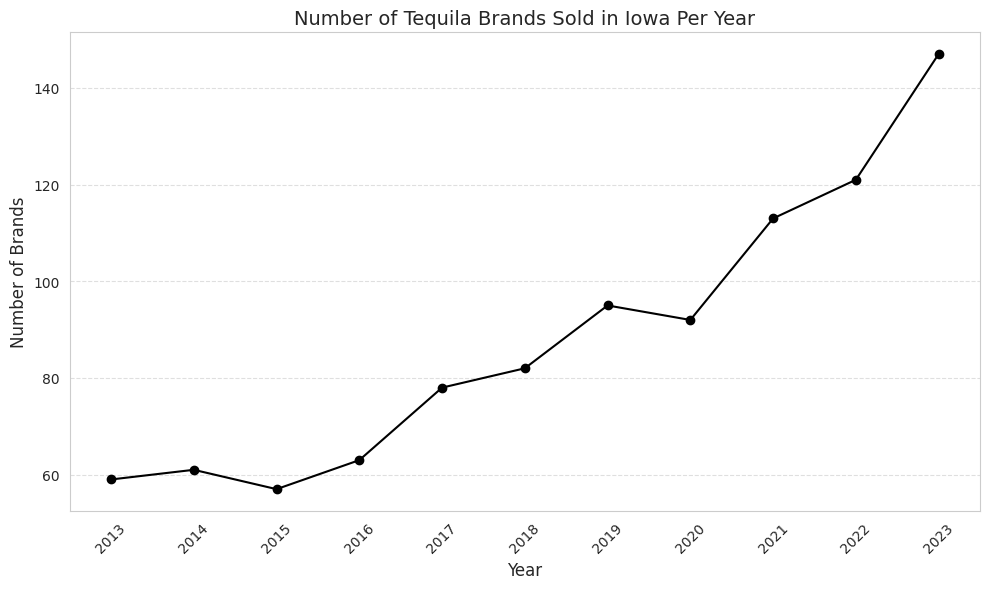

In [39]:
# seaborn style for better aesthetics
sns.set_style("whitegrid")

# calculate unique brands per year
unique_brands_per_year = tequila_df.groupby('year')['brand'].nunique().reset_index()

# plotting
plt.figure(figsize=(10, 6))
ax = plt.gca()  # get current axes

# plot the trend of unique tequila brands over the years
ax.plot(unique_brands_per_year['year'], unique_brands_per_year['brand'], marker='o', linestyle='-', color='black')

# set title and labels
plt.title('Number of Tequila Brands Sold in Iowa Per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Brands', fontsize=12)

# format y-axis ticks
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# set x-axis tick positions and labels
plt.xticks(unique_brands_per_year['year'], rotation=45)

# make the grid less pronounced
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.xaxis.grid(False)

# optimize spacing
plt.tight_layout()

# display the plot
plt.show()


From 2013 to 2023, the number of tequila brands sold in Iowa increased by 149%, rising from 59 to 147 brands.

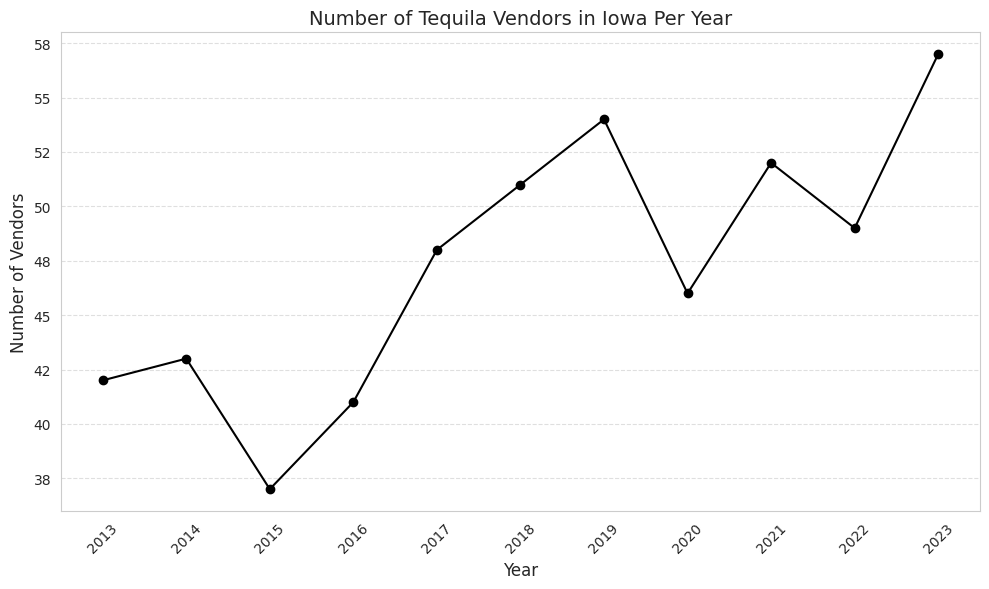

In [40]:
# seaborn style for better aesthetics
sns.set_style("whitegrid")

# calculate unique vendors per year
unique_vendors_per_year = tequila_df.groupby('year')['vendor_name'].nunique().reset_index()

# plotting
plt.figure(figsize=(10, 6))
ax = plt.gca()  # get current axes

# plot the trend of unique tequila vendors over the years
ax.plot(unique_vendors_per_year['year'], unique_vendors_per_year['vendor_name'], marker='o', linestyle='-', color='black')

# set title and labels
plt.title('Number of Tequila Vendors in Iowa Per Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Vendors', fontsize=12)

# format y-axis ticks
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: '{:.0f}'.format(x)))

# set x-axis tick positions and labels
plt.xticks(unique_vendors_per_year['year'], rotation=45)

# make the grid less pronounced
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.xaxis.grid(False)

# optimize spacing
plt.tight_layout()

# display the plot
plt.show()

From 2013 to 2023, the number of vendors operating in the  Iowa tequila market increased by 36%. The relatively smaller growth in number of vendors compared to number of brands is due to acquisition of successful brands by the incumbents.

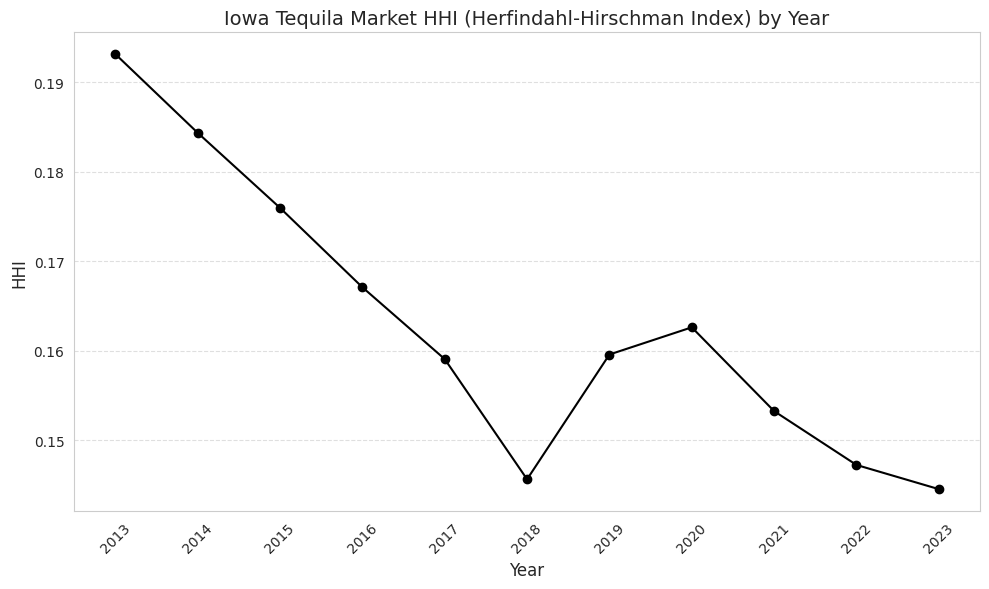

In [41]:
# seaborn style for better aesthetics
sns.set_style("whitegrid")

# calculate HHI for each year
HHI_by_year = (
    tequila_df.groupby(['year', 'vendor_name'])['sale_(dollars)'].sum()  # total sales by brand and year
    .groupby(level=0).apply(  # group by year and calculate HHI
        lambda x: ((x / x.sum())**2).sum()
    )
)

# reset index to have year as a column
HHI_by_year = HHI_by_year.reset_index()

# plotting
plt.figure(figsize=(10, 6))
ax = plt.gca()  # get current axes

# plot the trend of HHI over the years
ax.plot(HHI_by_year['year'], HHI_by_year['sale_(dollars)'], marker='o', linestyle='-', color='black')

# set title and labels
plt.title('Iowa Tequila Market HHI (Herfindahl-Hirschman Index) by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('HHI', fontsize=12)

# set x-axis tick positions and labels
all_years = HHI_by_year['year'].unique()
plt.xticks(all_years, rotation=45)

# make the grid less pronounced
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.xaxis.grid(False)

# optimize spacing
plt.tight_layout()

# display the plot
plt.show()


The tequila market in Iowa saw decreasing concentration from 2014 to 2019, hinting at growing competition. A surge in HHI in 2020 reflects market consolidations and the economic impact of events like the pandemic. The subsequent drop through 2022 suggests a resurgence of competition and possibly new entrants, with 2023 marking the least concentrated market.

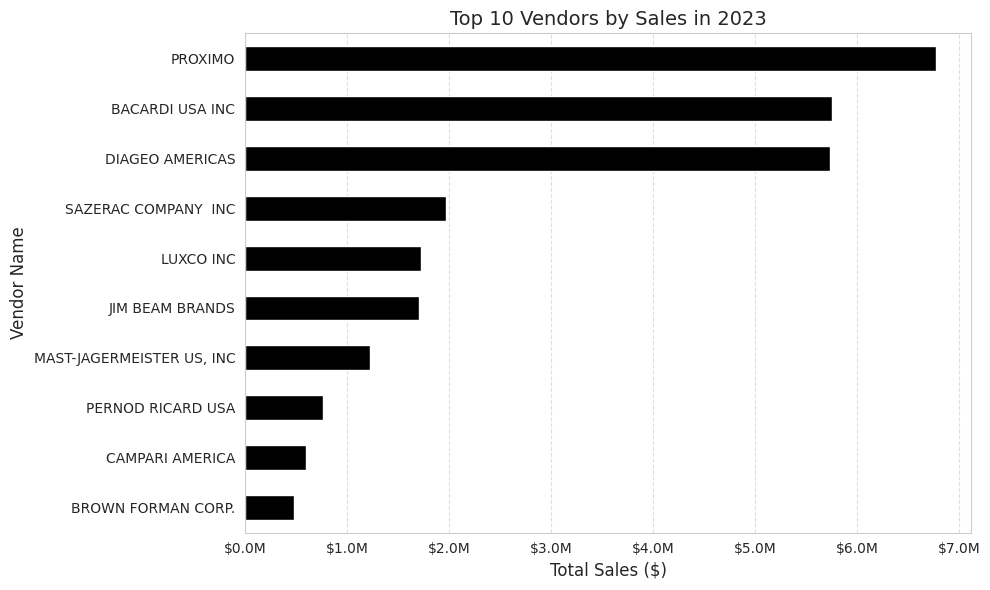

In [42]:
# seaborn style for better aesthetics
sns.set_style("whitegrid")

# filter the DataFrame for the year 2023
df_2023 = tequila_df[tequila_df["year"] == 2023]

# group by 'vendor_name', sum 'sale_(dollars)' for each vendor, sort, and take the top 10
top_10_vendors_sales = df_2023.groupby("vendor_name")["sale_(dollars)_cost"].sum().sort_values(ascending=False).head(10)

# Reverse the order of the DataFrame to put largest sales at the top
top_10_vendors_sales = top_10_vendors_sales[::-1]

# plotting
plt.figure(figsize=(10, 6))
ax = plt.gca()  # get current axes

# plot the top 10 vendors by sales in 2023 as horizontal bars with black bars
top_10_vendors_sales.plot(kind="barh", ax=ax, color='black')

# set title and labels
plt.title("Top 10 Vendors by Sales in 2023", fontsize=14)
plt.xlabel("Total Sales ($)", fontsize=12)
plt.ylabel("Vendor Name", fontsize=12)

# format x-axis ticks to display in millions and improve readability
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '${:.1f}M'.format(x / 1e6)))

# make the grid less pronounced
ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.yaxis.grid(False)

# optimize spacing
plt.tight_layout()

# display the plot
plt.show()

In [43]:
# filter the DataFrame for the year 2023
df_2023 = tequila_df[tequila_df["year"] == 2023]

# group by 'vendor_name', sum 'sale_(dollars)' for each vendor, and sort
vendor_sales_2023 = df_2023.groupby("vendor_name")["sale_(dollars)"].sum().sort_values(ascending=False)

# calculate total sales for 2023
total_sales_2023 = vendor_sales_2023.sum()

# calculate market share for the top 3 vendors
top_3_market_share = (vendor_sales_2023.head(3) / total_sales_2023) * 100

# display the market share of the top 3 vendors
print("Market Share of Top 3 Vendors in 2023:")
print(top_3_market_share)

Market Share of Top 3 Vendors in 2023:
vendor_name
PROXIMO            23.041371
BACARDI USA INC    19.580112
DIAGEO AMERICAS    19.511031
Name: sale_(dollars), dtype: float64


Proximo, Bacardi, and Diageo, are the leading vendors in terms of sales and collectively dominate the tequila market in Iowa, holding a combined 62% market share in 2023.

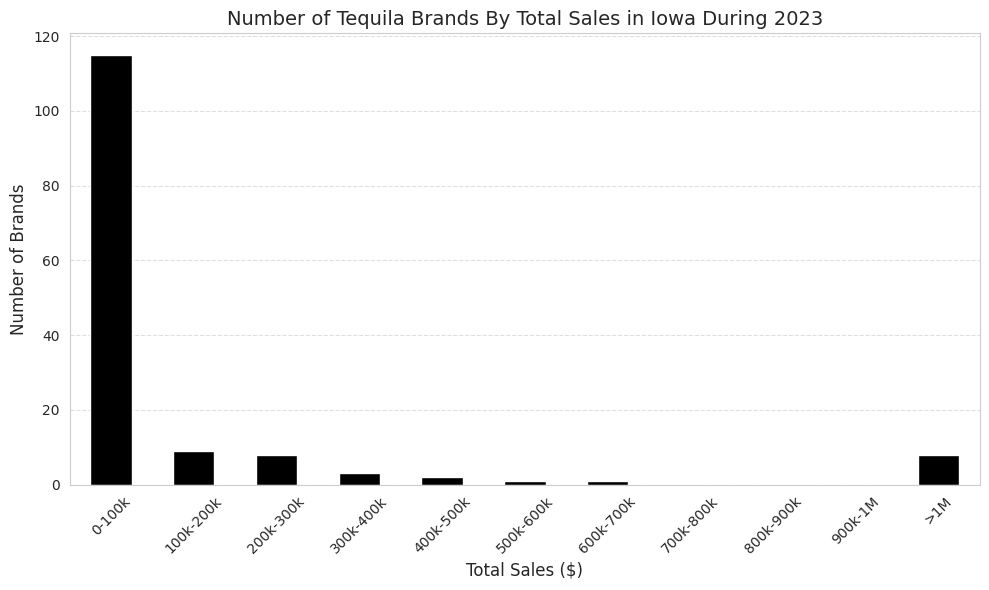

In [44]:
# seaborn style for better aesthetics
sns.set_style("whitegrid")

# filter the dataset for sales in 2023
tequila_df_2023 = tequila_df[tequila_df['year'] == 2023]

# calculate total sales per brand for 2023
total_sales_per_brand_2023 = tequila_df_2023.groupby('brand')['sale_(dollars)_cost'].sum().reset_index()

# define bins and labels for categorizing sales
bins = [0, 100000, 200000, 300000, 400000, 500000, 600000, 700000, 800000, 900000, 1000000, np.inf]
labels = ['0-100k', '100k-200k', '200k-300k', '300k-400k', '400k-500k', '500k-600k', '600k-700k', '700k-800k', '800k-900k', '900k-1M', '>1M']

# bin the sales into categories for 2023 data
total_sales_per_brand_2023['sales_category'] = pd.cut(total_sales_per_brand_2023['sale_(dollars)_cost'], bins=bins, labels=labels)

# count the number of brands in each category for 2023
brands_per_category_2023 = total_sales_per_brand_2023['sales_category'].value_counts().sort_index()

# create a bar graph for 2023 data
plt.figure(figsize=(10, 6))
ax = plt.gca()  # get current axes

# plot the number of tequila brands by total sales in Iowa during 2023 with black bars
brands_per_category_2023.plot(kind='bar', color='black', ax=ax)

# set title and labels
plt.title('Number of Tequila Brands By Total Sales in Iowa During 2023', fontsize=14)
plt.xlabel('Total Sales ($)', fontsize=12)
plt.ylabel('Number of Brands', fontsize=12)
plt.xticks(rotation=45)

# make the grid less pronounced
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.xaxis.grid(False)

# optimize spacing
plt.tight_layout()

# display the plot
plt.show()

The Iowa tequila market consists of a large number of small players (brands with sales under \$100k) and a small number of very successful players (brands with sales over \$1M).

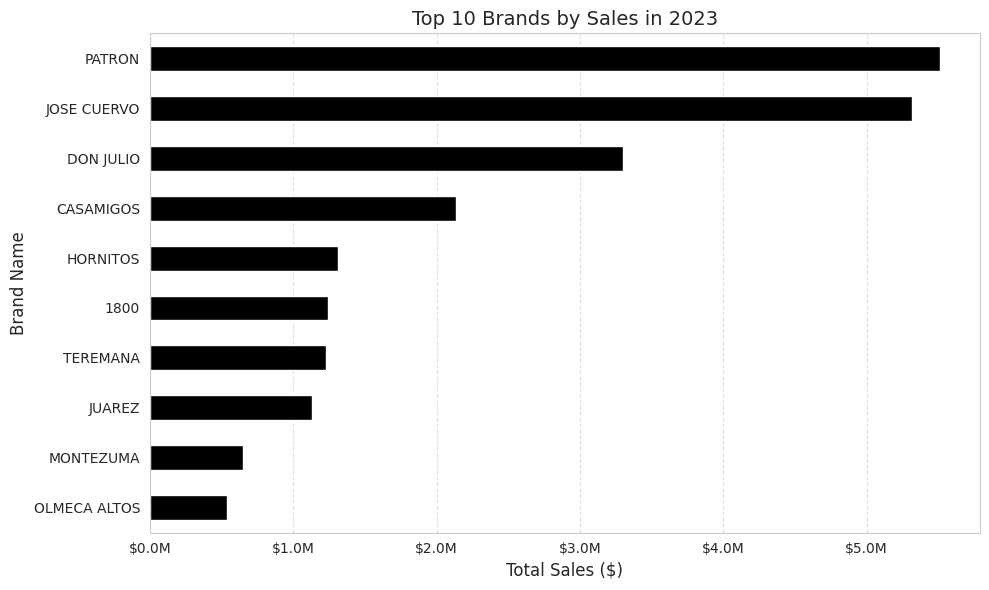

In [45]:
# seaborn style for better aesthetics
sns.set_style("whitegrid")

# filter the DataFrame for the year 2023
df_2023 = tequila_df[tequila_df["year"] == 2023]

# group by 'brand', sum 'sale_(dollars)' for each brand, sort, and take the top 10
top_10_brands_sales = df_2023.groupby("brand")["sale_(dollars)_cost"].sum().sort_values(ascending=False).head(10)

# Reverse the order of the DataFrame to put largest sales at the top
top_10_brands_sales = top_10_brands_sales[::-1]

# plotting
plt.figure(figsize=(10, 6))
ax = plt.gca()  # get current axes

# plot the top 10 brands by sales in 2023 as horizontal bars with black bars
top_10_brands_sales.plot(kind="barh", ax=ax, color='black')

# set title and labels
plt.title("Top 10 Brands by Sales in 2023", fontsize=14)
plt.xlabel("Total Sales ($)", fontsize=12)
plt.ylabel("Brand Name", fontsize=12)

# format x-axis ticks to display in millions and improve readability
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '${:.1f}M'.format(x / 1e6)))

# make the grid less pronounced
ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.yaxis.grid(False)

# optimize spacing
plt.tight_layout()

# display the plot
plt.show()

In [46]:
# filter the DataFrame for the year 2023
df_2023 = tequila_df[tequila_df["year"] == 2023]

# group by 'brand', sum 'sale_(dollars)' for each brand, and sort
brand_sales_2023 = df_2023.groupby("brand")["sale_(dollars)_cost"].sum().sort_values(ascending=False)

# calculate total sales for 2023
total_sales_2023 = brand_sales_2023.sum()

# calculate market share for the top 3 brands
top_10_market_share = (brand_sales_2023.head(10) / total_sales_2023) * 100

# display the market share of the top 3 brands
print("Market Share of Top 10 Brands in 2023:")
print(top_10_market_share)

Market Share of Top 10 Brands in 2023:
brand
PATRON          18.736636
JOSE CUERVO     18.063296
DON JULIO       11.207550
CASAMIGOS        7.260063
HORNITOS         4.465465
1800             4.227726
TEREMANA         4.176733
JUAREZ           3.846945
MONTEZUMA        2.203163
OLMECA ALTOS     1.837610
Name: sale_(dollars)_cost, dtype: float64



In 2023, the top two tequila brands were PATRON and JOSE CUERVO, each with about 18% of the market. DON JULIO was next with 11%. CASAMIGOS had 7%. Brands like HORNITOS, 1800, TEREMANA, and JUAREZ each had around 4%. MONTEZUMA and OLMECA ALTOS were smaller, with 2%.

In [47]:
# filter 'tequila_df' for Teremana and the years 2020 to 2023
teremana_sales = tequila_df[(tequila_df['brand'] == 'TEREMANA') & (tequila_df['year'].between(2020, 2023))]

# group by year and sum up the sales
teremana_yearly_sales = teremana_sales.groupby('year')['sale_(dollars)_cost'].sum()

# display the sales for Teremana for each year from 2020 to 2023
print(teremana_yearly_sales)

year
2020     167559.43
2021     549483.29
2022     937130.62
2023    1229459.15
Name: sale_(dollars)_cost, dtype: float64


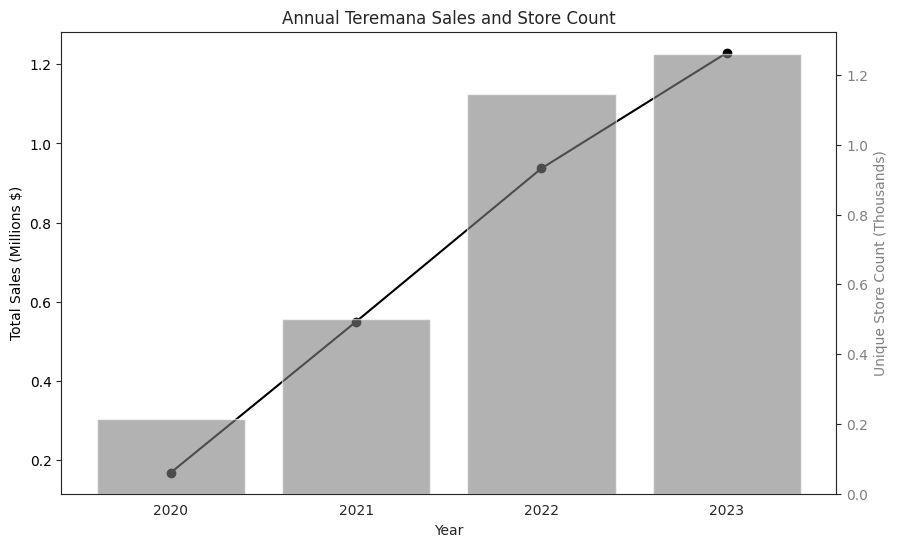

In [48]:
# filter for Teremana brand and the years 2020 to 2023
teremana_df = tequila_df[(tequila_df['brand'] == 'TEREMANA') & (tequila_df['year'].isin([2020, 2021, 2022, 2023]))]

# group by year to calculate total sales and unique store count
annual_summary = teremana_df.groupby('year').agg(
    Total_Sales=('sale_(dollars)_cost', 'sum'),
    Unique_Stores=('store_name', 'nunique')
).reset_index()

# convert Total Sales to millions and Unique Store Count to thousands
annual_summary['Total_Sales'] /= 1e6  # Convert dollars to millions
annual_summary['Unique_Stores'] /= 1e3  # Convert store count to thousands

# creating figure and axis for line chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# disable seaborn grid style by setting to white background
sns.set_style("white")

# line chart for Total Sales in millions
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Sales (Millions $)', color='black')
ax1.plot(annual_summary['year'], annual_summary['Total_Sales'], color='black', marker='o', linestyle='-')
ax1.tick_params(axis='y', labelcolor='black')
ax1.set_xticks([2020, 2021, 2022, 2023])  # Set x-ticks to specific years

# create a second axis for bar chart for Unique Store Count in thousands
ax2 = ax1.twinx()
ax2.set_ylabel('Unique Store Count (Thousands)', color='grey')
ax2.bar(annual_summary['year'], annual_summary['Unique_Stores'], color='grey', alpha=0.6)
ax2.tick_params(axis='y', labelcolor='grey')
ax2.set_xticks([2020, 2021, 2022, 2023])

# title and layout adjustments
plt.title('Annual Teremana Sales and Store Count')

# remove grid lines
ax1.grid(False)
ax2.grid(False)

# show plot
plt.show()

The top 10 brands comprised 74% of Iowa's tequila sales, with 9 having longstanding legacies of at least a decade or centuries in the case of Jose Cuervo. However, Teremana only launched in 2020, and has seen 633% sales growth in just 3 years.

## D. Stores

In [49]:
pip install adjustText

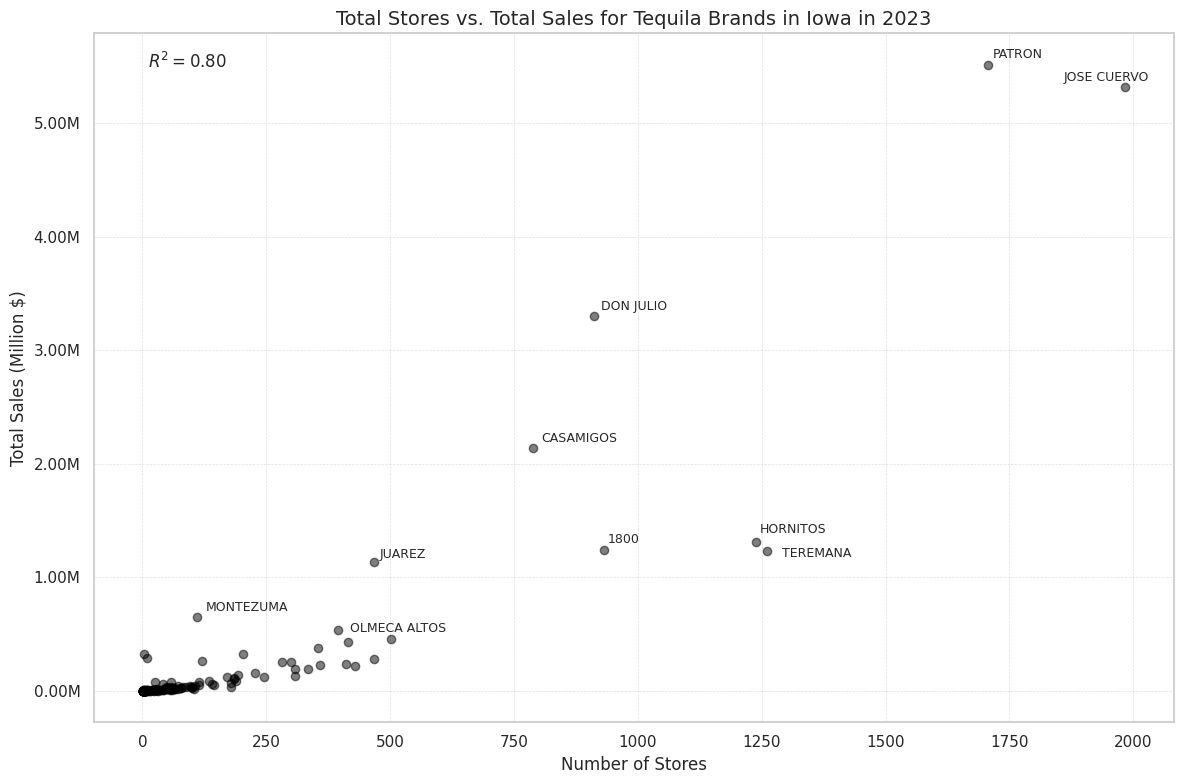

In [50]:
from adjustText import adjust_text

# seaborn style for better aesthetics
sns.set(style="whitegrid", rc={'grid.linestyle': '--', 'grid.color': 'grey', 'grid.alpha': 0.25, 'grid.linewidth': 0.5})

# filter the DataFrame for the year 2023
data_2023 = tequila_df[tequila_df['year'] == 2023]

# calculate total sales for each brand
total_sales_by_brand = data_2023.groupby('brand')['sale_(dollars)_cost'].sum()

# count the number of unique stores for each brand
unique_stores_by_brand = data_2023.groupby('brand')['store_name'].nunique()

# create a DataFrame for plotting
plot_data = pd.DataFrame({
    'Total Sales': total_sales_by_brand,
    'Unique Stores': unique_stores_by_brand
}).reset_index()

# calculate the R^2 value
slope, intercept, r_value, _, _ = linregress(plot_data['Unique Stores'], plot_data['Total Sales'])
r_squared = r_value**2

# scatter plot with Seaborn styling
plt.figure(figsize=(12, 8))
plt.scatter(plot_data['Unique Stores'], plot_data['Total Sales'] / 1e6, color='black', alpha=0.5)

# prepare text annotations for brands with more than $500000 in sales
texts = []
for _, row in plot_data[plot_data['Total Sales'] > 500000].iterrows():
    texts.append(plt.text(row['Unique Stores'], row['Total Sales'] / 1e6, row['brand'], fontsize=9))

# use adjust_text to optimize label positions without arrows
adjust_text(texts)

# setting title and labels, adjusting y-label to indicate sales are in millions
plt.title('Total Stores vs. Total Sales for Tequila Brands in Iowa in 2023', fontsize=14)
plt.xlabel('Number of Stores', fontsize=12)
plt.ylabel('Total Sales (Million $)', fontsize=12)

# annotate R^2 value
plt.annotate(f'$R^2 = {r_squared:.2f}$', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12)

# format y-axis to display sales values in millions
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}M'))

plt.grid(True)
plt.tight_layout()
plt.show()

Looking at sales and market presence, 80% of the variance in sales can be attributed to the number of stores a brand is present in. This strong correlation underscores the importance of store presence as a major driver of sales. The more extensive a brand's footprint in retail outlets, the higher its sales figures tend to be.

## E. Sizing

In [51]:
# filter the DataFrame for the year 2023
tequila_2023 = tequila_df[tequila_df['year'] == 2023]

# group by 'bottle_volume_ml', count unique brands for each volume, and sum bottles_sold
unique_brand_and_bottles_sold_per_volume = tequila_2023.groupby('bottle_volume_(ml)').agg({
    'brand': pd.Series.nunique,
    'bottles_sold': 'sum'
}).reset_index()

# Rrnaming the columns for clarity
unique_brand_and_bottles_sold_per_volume.columns = ['Bottle Volume (ml)', 'Brand Count', 'Total Bottles Sold']

# display the table
unique_brand_and_bottles_sold_per_volume

,Bottle Volume (ml),Brand Count,Total Bottles Sold
0,50,8,45783
1,100,2,28940
2,200,2,137877
3,375,13,300309
4,700,4,1434
5,750,135,904157
6,1000,24,411220
7,1750,20,87658


750 ml is by far the most common bottle size for tequila. This size, often referred to as a "standard bottle," serves as the industry standard for a variety of reasons.

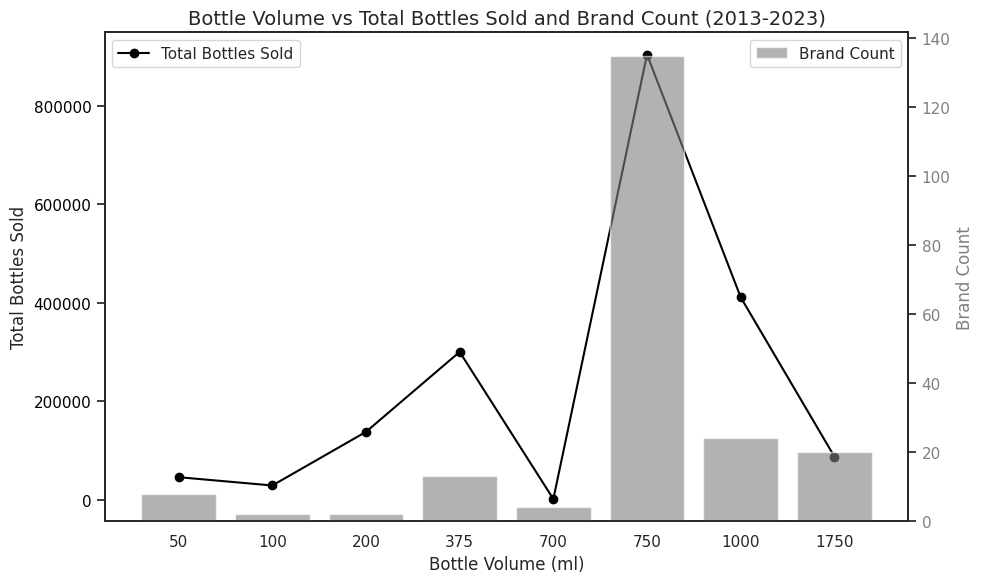

In [52]:
# set the seaborn style to white
sns.set_style("white")

# create figure and first axis for the line chart
fig, ax1 = plt.subplots(figsize=(10, 6))

# line chart for Total Bottles Sold
ax1.set_xlabel('Bottle Volume (ml)', fontsize=12)
ax1.set_ylabel('Total Bottles Sold', fontsize=12)
ax1.plot(unique_brand_and_bottles_sold_per_volume['Bottle Volume (ml)'].astype(str), unique_brand_and_bottles_sold_per_volume['Total Bottles Sold'], color='black', marker='o', label='Total Bottles Sold')
ax1.tick_params(axis='y', labelcolor='black')

# create a second axis for the bar chart
ax2 = ax1.twinx()
ax2.set_ylabel('Brand Count', fontsize=12, color='grey')
ax2.bar(unique_brand_and_bottles_sold_per_volume['Bottle Volume (ml)'].astype(str), unique_brand_and_bottles_sold_per_volume['Brand Count'], color='grey', alpha=0.6, label='Brand Count', )
ax2.tick_params(axis='y', labelcolor='grey')

# set x-ticks
ax1.set_xticks(unique_brand_and_bottles_sold_per_volume['Bottle Volume (ml)'].astype(str))

# remove grid lines for both axes
ax1.grid(False)
ax2.grid(False)

# Set the title and adjust the layout
ax1.set_title('Bottle Volume vs Total Bottles Sold and Brand Count (2013-2023)', fontsize=14)

# show legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# adjust layout and display the plot
plt.tight_layout()
plt.show()


## F. Pricing

In [53]:
# filtering dataset for 2023 sales
data_2023 = tequila_df[tequila_df['year'] == 2023]

# calculate total sales for each brand
total_sales_by_brand = data_2023.groupby('brand')['sale_(dollars)_cost'].sum()

# calculate the average price per bottle sold in 2023 for each brand
average_price_per_bottle = data_2023.groupby('brand')['state_bottle_cost'].mean()

# create a DataFrame for analysis
plot_data = pd.DataFrame({
    'Brand': total_sales_by_brand.index,
    'Total Sales': total_sales_by_brand.values,
    'Average Price per Bottle': average_price_per_bottle.values
})

# filter to top 10 brands by total sales
top_brands = plot_data.nlargest(10, 'Total Sales')

# display the average price per bottle for the top brands
top_brands = top_brands[['Brand', 'Average Price per Bottle']]
top_brands

,Brand,Average Price per Bottle
119,PATRON,23.378181
82,JOSE CUERVO,11.158524
53,DON JULIO,38.894472
31,CASAMIGOS,28.042786
77,HORNITOS,15.778376
0,1800,17.557758
135,TEREMANA,15.732853
84,JUAREZ,9.665429
108,MONTEZUMA,7.239832
114,OLMECA ALTOS,16.046918


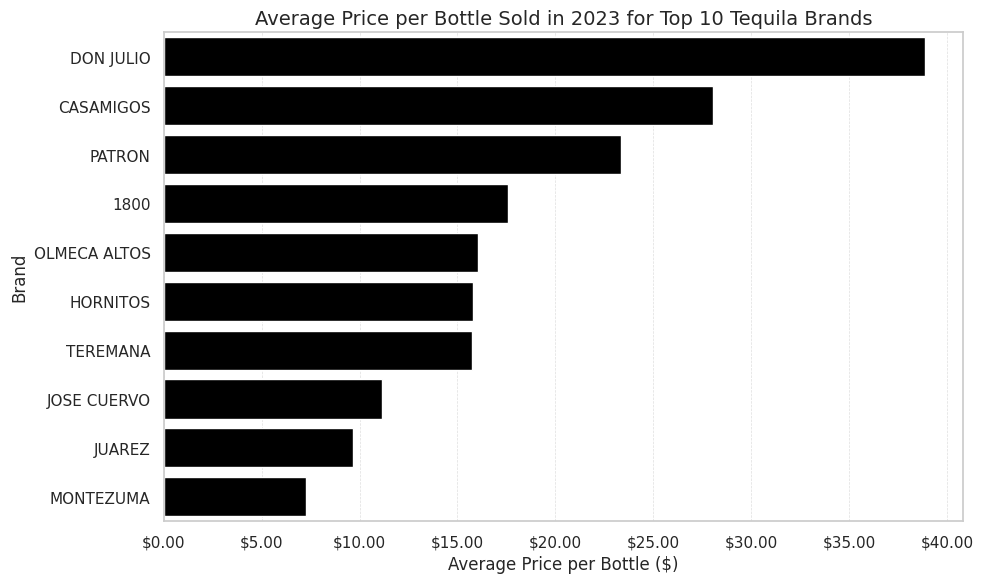

In [54]:
# seaborn style for better aesthetics
sns.set_style("whitegrid")

# sort data for better visualization
top_brands_sorted = top_brands.sort_values(by='Average Price per Bottle', ascending=False)

# plotting
plt.figure(figsize=(10, 6))
ax = plt.gca()  # get current axes

# plot the top brands by average price per bottle in 2023 as horizontal bars
sns.barplot(x='Average Price per Bottle', y='Brand', data=top_brands_sorted, color='black')

# set title and labels
plt.title("Average Price per Bottle Sold in 2023 for Top 10 Tequila Brands", fontsize=14)
plt.xlabel("Average Price per Bottle ($)", fontsize=12)
plt.ylabel("Brand", fontsize=12)

# format x-axis ticks to display price values and improve readability
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: '${:,.2f}'.format(x)))

# make the grid less pronounced
ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.yaxis.grid(False)

# optimize spacing
plt.tight_layout()

# display the plot
plt.show()

In [55]:
pip install mplcursors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 27.2 MB/s eta 0:00:00
  Created wheel for mplcursors: filename=mplcursors-0.5.3-py3-none-any.whl size=20728 sha256=e5938f58ada91a44fd950a8dae12dbf359b23ec6557cb50070f99362044f293b
  Stored in directory: /root/.cache/pip/wheels/83/43/92/44f9515471f56877c774a515a2902d3e5484ea1bc7fd412d03
Successfully built mplcursors
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


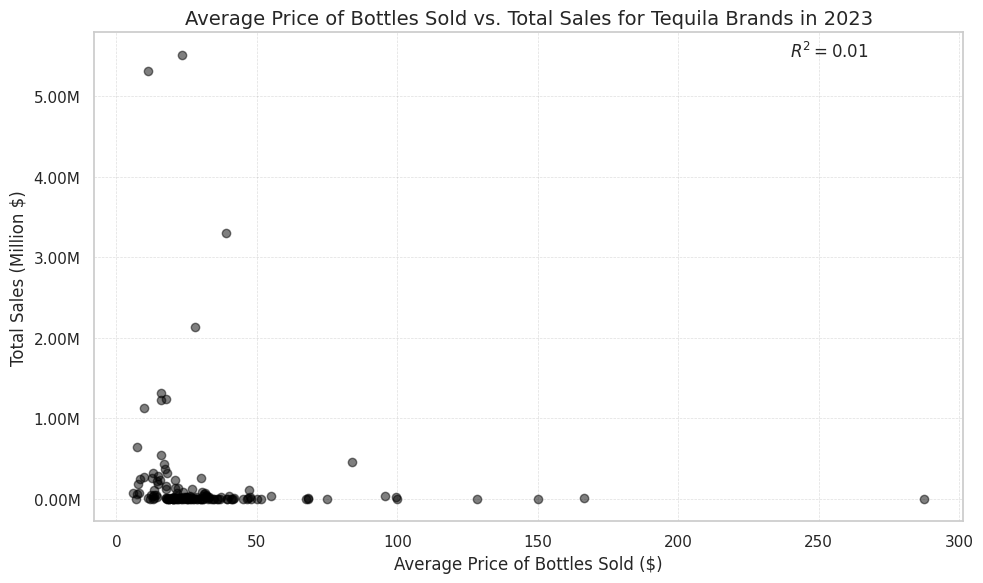

In [56]:
import mplcursors

# filter the DataFrame for the year 2023
data_2023 = tequila_df[tequila_df['year'] == 2023]

# calculate average state bottle retail price per brand for 2023
average_state_bottle_retail_by_brand_2023 = data_2023.groupby('brand')['state_bottle_cost'].mean()

# calculate total sales for each brand for 2023
total_sales_by_brand_2023 = data_2023.groupby('brand')['sale_(dollars)_cost'].sum()

# create a DataFrame for plotting for 2023
plot_data_2023 = pd.DataFrame({
    'Average State Bottle Retail': average_state_bottle_retail_by_brand_2023,
    'Total Sales': total_sales_by_brand_2023
}).reset_index()

# calculate the R^2 value for 2023 data
slope, intercept, r_value, _, _ = linregress(plot_data_2023['Average State Bottle Retail'], plot_data_2023['Total Sales'])
r_squared = r_value**2

# seaborn style for better aesthetics
sns.set(style="whitegrid", rc={'grid.linestyle': '--', 'grid.color': 'grey', 'grid.alpha': 0.25, 'grid.linewidth': 0.5})

# scatter plot with Seaborn styling for 2023 data
plt.figure(figsize=(10, 6))
scatter = plt.scatter(plot_data_2023['Average State Bottle Retail'], plot_data_2023['Total Sales'] / 1e6, color='black', alpha=0.5)

# use mplcursors for interactive, draggable annotations
cursor = mplcursors.cursor(scatter, hover=True)
@cursor.connect("add")
def on_add(sel):
    sel.annotation.set_text(plot_data_2023['brand'][sel.target.index])
    sel.annotation.get_bbox_patch().set(fc="white", alpha=0.6)

# setting title and labels, adjusting y-label to indicate sales are in millions for 2023 data
plt.title('Average Price of Bottles Sold vs. Total Sales for Tequila Brands in 2023', fontsize=14)
plt.xlabel('Average Price of Bottles Sold ($)', fontsize=12)
plt.ylabel('Total Sales (Million $)', fontsize=12)

# annotate R^2 value for 2023 data
plt.annotate(f'$R^2 = {r_squared:.2f}$', xy=(0.80, 0.95), xycoords='axes fraction', fontsize=12)

# format y-axis to display sales values in millions for 2023 data
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:.2f}M'))

plt.grid(True)
plt.tight_layout()
plt.show()

In [57]:
# filter the DataFrame for the year 2023
tequila_2023 = tequila_df[tequila_df['year'] == 2023]

# define bin edges and labels for the price ranges
bin_edges = list(range(0, 101, 10)) + [float('inf')]  # extends up to 100, then adds infinity for $100 and above
bin_labels = [f"${left}-${left+9}.99" for left in range(0, 100, 10)]
bin_labels.append("$100+")  # label for $100 and above

# bin the data according to 'state_bottle_cost'
tequila_2023['Price Range'] = pd.cut(tequila_2023['state_bottle_cost'], bins=bin_edges, labels=bin_labels, right=False, include_lowest=True)

# group by 'Price Range' and count unique brands in each bin
unique_brand_count = tequila_2023.groupby('Price Range')['brand'].nunique()

# convert the frequency data to a DataFrame for easier handling
unique_brand_count_df = unique_brand_count.reset_index()
unique_brand_count_df.columns = ['Price Range', 'Number of Brands']

# show the table
print(unique_brand_count_df)

   Price Range  Number of Brands
0     $0-$9.99                18
1   $10-$19.99                57
2   $20-$29.99                90
3   $30-$39.99                52
4   $40-$49.99                29
5   $50-$59.99                19
6   $60-$69.99                15
7   $70-$79.99                14
8   $80-$89.99                 8
9   $90-$99.99                 7
10       $100+                16


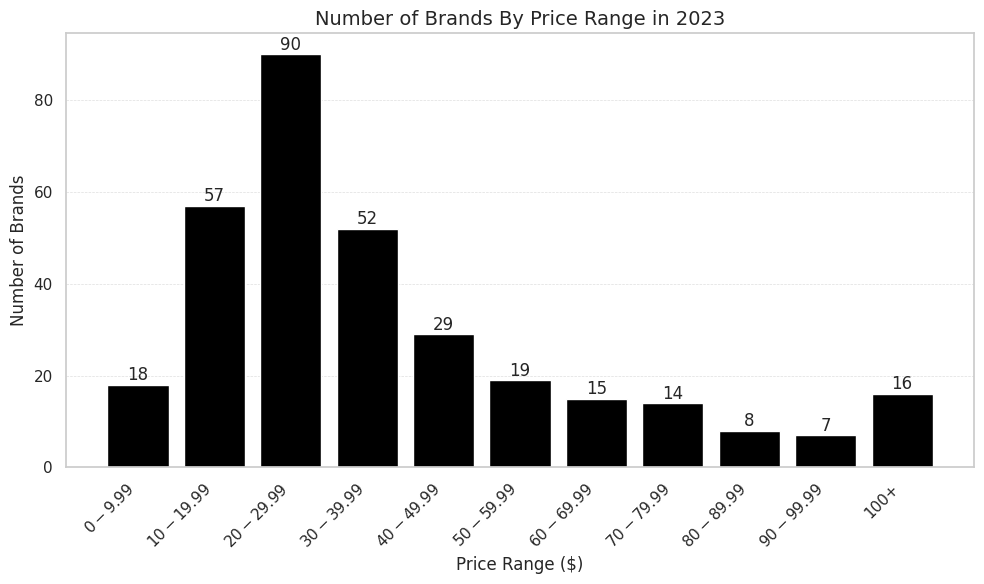

In [58]:
# data for plot
price_ranges = ["$0-$9.99", "$10-$19.99", "$20-$29.99", "$30-$39.99", "$40-$49.99",
                "$50-$59.99", "$60-$69.99", "$70-$79.99", "$80-$89.99", "$90-$99.99", "100+"]
frequencies = [18, 57, 90, 52, 29, 19, 15, 14, 8, 7, 16]  # Updated frequencies from your data

# plotting the distribution chart with updated bins and seaborn style
sns.set_style("whitegrid")  # seaborn style for better aesthetics

plt.figure(figsize=(10, 6))
plt.bar(price_ranges, frequencies, color='black')

# labelling
plt.title("Number of Brands By Price Range in 2023", fontsize=14)
plt.xlabel("Price Range ($)", fontsize=12)
plt.ylabel("Number of Brands", fontsize=12)

# rotate x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# make the grid less pronounced
ax = plt.gca()  # Get current axes
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.xaxis.grid(False)

# add text labels above the bars for clarity
for i, frequency in enumerate(frequencies):
    plt.text(i, frequency + 0.1, str(frequency), ha='center', va='bottom')

plt.tight_layout()  # optimize spacing

plt.show()  # display the plot

In [59]:
# filter the DataFrame for the year 2023
tequila_2023 = tequila_df[tequila_df['year'] == 2023]

# define bin edges to reflect price ranges, extends up to 100, then adds infinity for $100 and above
bin_edges = list(range(0, 101, 10)) + [float('inf')]

# adjust the end of each range to .99 for intervals up to $99.99, then add $100+ for the last bin
bin_labels = [f"${left}-${left+9}.99" for left in range(0, 100, 10)]
bin_labels.append("$100+")

# bin the bottle prices into defined ranges
binned_bottle_prices = pd.cut(tequila_2023['state_bottle_cost'], bins=bin_edges, labels=bin_labels, right=False, include_lowest=True)

# create a new DataFrame to map total bottles sold to the corresponding price bin
bottles_per_price_bin = pd.DataFrame({'Price Bin': binned_bottle_prices, 'Total Bottles': tequila_2023['bottles_sold']})

# group by the price bin and sum up the total bottles for each bin
total_bottles_per_price_range = bottles_per_price_bin.groupby('Price Bin').sum()

# reset index to turn the Series into a DataFrame
total_bottles_per_price_range.reset_index(inplace=True)

# rename the columns appropriately
total_bottles_per_price_range.columns = ['Price Range', 'Total Bottles Sold']

# show the table
print(total_bottles_per_price_range)

   Price Range  Total Bottles Sold
0     $0-$9.99              657906
1   $10-$19.99              827811
2   $20-$29.99              314037
3   $30-$39.99               98144
4   $40-$49.99                2199
5   $50-$59.99                4322
6   $60-$69.99                3026
7   $70-$79.99                1248
8   $80-$89.99                 538
9   $90-$99.99                7270
10       $100+                 877


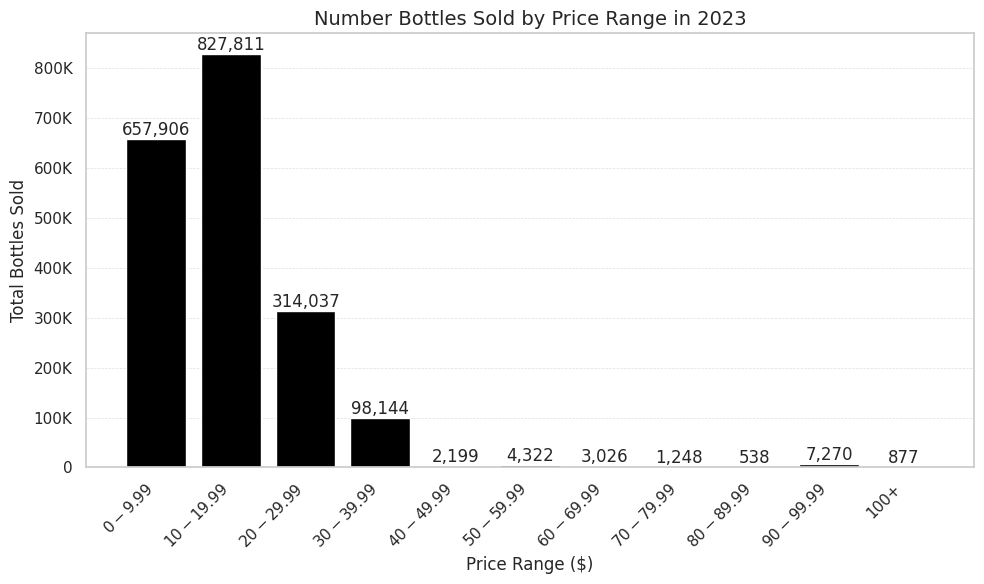

In [60]:
# bottles sold and price ranges
price_ranges = ["$0-$9.99", "$10-$19.99", "$20-$29.99", "$30-$39.99", "$40-$49.99",
                "$50-$59.99", "$60-$69.99", "$70-$79.99", "$80-$89.99", "$90-$99.99", "100+"]
total_bottles_sold = [657906, 827811, 314037, 98144, 2199, 4322, 3026, 1248, 538, 7270, 877]

# setting seaborn style for aesthetics
sns.set_style("whitegrid")

# creating the figure and setting the size
plt.figure(figsize=(10, 6))
plt.bar(price_ranges, total_bottles_sold, color='black')

# formatting y-axis to avoid scientific notation
def thousands_formatter(x, pos):
    return f'{int(x / 1000)}K' if x >= 1000 else f'{int(x)}'
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(thousands_formatter))

# adding title and labels
plt.title("Number Bottles Sold by Price Range in 2023", fontsize=14)
plt.xlabel("Price Range ($)", fontsize=12)
plt.ylabel("Total Bottles Sold", fontsize=12)

# rotating x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# adjusting grid visibility
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.xaxis.grid(False)

# adding text labels above the bars for clarity
for i, total in enumerate(total_bottles_sold):
    plt.text(i, total + 0.1, f"{total:,}", ha='center', va='bottom')

plt.tight_layout()  # optimize spacing
plt.show()  # display the plot

In [61]:
# dilter the DataFrame for the year 2023
tequila_2023 = tequila_df[tequila_df['year'] == 2023]

# define bin edges to reflect price ranges of the state bottle cost, extends up to 100, then adds infinity for $100 and above
bin_edges = list(range(0, 101, 10)) + [float('inf')]

# adjust the end of each range to .99 for intervals up to $99.99, then add $100+ for the last bin
bin_labels = [f"${left}-${left+9}.99" for left in range(0, 100, 10)]
bin_labels.append("$100+")

# bin the state_bottle_cost into defined ranges
binned_bottle_costs = pd.cut(tequila_2023['state_bottle_cost'], bins=bin_edges, labels=bin_labels, right=False, include_lowest=True)

# create a new DataFrame to map total sales cost to the corresponding state bottle cost bin
sales_per_bottle_cost_bin = pd.DataFrame({'State Bottle Cost Bin': binned_bottle_costs, 'Total Sales Cost': tequila_2023['sale_(dollars)_cost']})

# group by the state bottle cost bin and sum up the total sales cost for each bin
total_sales_cost_per_bottle_cost_range = sales_per_bottle_cost_bin.groupby('State Bottle Cost Bin').sum()

# reset index to turn the Series into a DataFrame
total_sales_cost_per_bottle_cost_range.reset_index(inplace=True)

# rename the columns appropriately
total_sales_cost_per_bottle_cost_range.columns = ['State Bottle Cost Range', 'Total Sales Cost']

# show the table
total_sales_cost_per_bottle_cost_range

,State Bottle Cost Range,Total Sales Cost
0,$0-$9.99,4330348.77
1,$10-$19.99,12002996.64
2,$20-$29.99,8323142.50
3,$30-$39.99,3244035.43
4,$40-$49.99,98734.17
5,$50-$59.99,243828.15
6,$60-$69.99,191819.49
7,$70-$79.99,91441.36
8,$80-$89.99,45189.19
9,$90-$99.99,714600.27


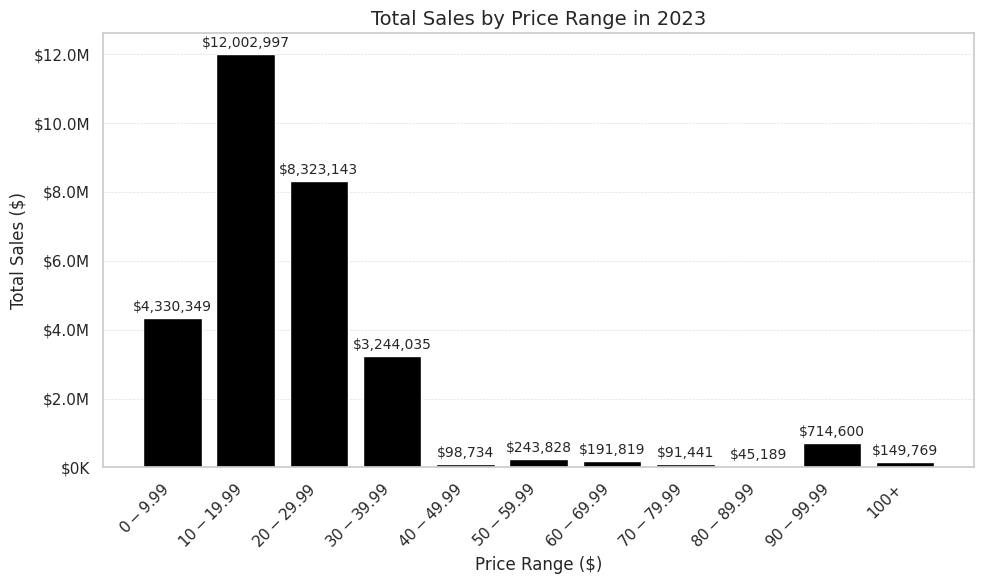

In [62]:
# data for the plot
price_ranges = ["$0-$9.99", "$10-$19.99", "$20-$29.99", "$30-$39.99", "$40-$49.99",
                "$50-$59.99", "$60-$69.99", "$70-$79.99", "$80-$89.99", "$90-$99.99", "100+"]
total_sales = [4330349, 12002997, 8323143, 3244035, 98734,
               243828, 191819, 91441, 45189, 714600, 149769]

# setting Seaborn style for aesthetics
sns.set_style("whitegrid")

# creating the figure and setting the size
plt.figure(figsize=(10, 6))
plt.bar(price_ranges, total_sales, color='black')

# formatting y-axis to show currency
def millions_formatter(x, pos):
    return f'${x * 1e-6:.1f}M' if x >= 1e6 else f'${x * 1e-3:.0f}K'
ax = plt.gca()
ax.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

# adding title and labels
plt.title("Total Sales by Price Range in 2023", fontsize=14)
plt.xlabel("Price Range ($)", fontsize=12)
plt.ylabel("Total Sales ($)", fontsize=12)

# totating x-axis labels for better readability
plt.xticks(rotation=45, ha="right")

# adjusting grid visibility
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.xaxis.grid(False)

# adding text labels above the bars for clarity
for i, total in enumerate(total_sales):
    plt.text(i, total + 0.01 * max(total_sales), f"${total:,}", ha='center', va='bottom',fontsize=10)

plt.tight_layout()  # optimize spacing
plt.show()  # display the plot

In [63]:
import pandas as pd

# filtering the dataset for the brand "TEREMANA" and the year 2023
teremana_2023 = tequila_df[(tequila_df['brand'] == 'TEREMANA') & (tequila_df['year'] == 2023)]

# grouping by state bottle cost and aggregating the required data
summary_table = teremana_2023.groupby('state_bottle_cost').agg({
    'bottles_sold': 'sum',  # Sum of bottles sold
    'item_description': [
        pd.Series.nunique,  # Count of unique item descriptions
        lambda x: list(x.unique())  # List of unique item descriptions
    ]
}).reset_index()

# renaming columns for clarity
summary_table.columns = ['state_bottle_cost', 'total_bottles_sold', 'unique_items_count', 'list_of_item_descriptions']

# displaying the results
summary_table

,state_bottle_cost,total_bottles_sold,unique_items_count,list_of_item_descriptions
0,8.52,11284,1,[TEREMANA BLANCO TEQUILA]
1,9.53,9968,1,[TEREMANA REPOSADO TEQUILA]
2,15.91,33635,1,[TEREMANA BLANCO TEQUILA]
3,17.40,19290,1,[TEREMANA REPOSADO TEQUILA]
4,18.46,4642,1,[TEREMANA BLANCO TEQUILA]
5,19.95,1738,1,[TEREMANA REPOSADO TEQUILA]
6,21.32,2213,1,[TEREMANA ANEJO TEQUILA]


# 4. Teremana Growth Plan

## A. Target New Stores

In [64]:
# importing tequila dataset
tequila_df = pd.read_csv('/content/drive/MyDrive/iowa_tequila_sales_with_brands.csv')

In [65]:
# filter for 2023 data
data_2023 = tequila_df[tequila_df['year'] == 2023]

# count unique stores
unique_stores_count = data_2023['store_name'].nunique()

print("Number of unique stores in 2023:", unique_stores_count)

Number of unique stores in 2023: 2045


In [66]:
# filter the DataFrame for Teremana in 2023
teremana_2023_stores = tequila_df[(tequila_df['brand'] == 'TEREMANA') & (tequila_df['year'] == 2023)]['store_name'].unique()

# cunt of unique stores selling Teremana in 2023
count_teremana_2023_stores = len(teremana_2023_stores)
print("Number of stores that sell Teremana in 2023:", count_teremana_2023_stores)

Number of stores that sell Teremana in 2023: 1261


In [67]:
# filter the DataFrame for 2023 and then for relevant brands
jose_cuervo_2023_stores = tequila_df[(tequila_df['brand'] == 'JOSE CUERVO') & (tequila_df['year'] == 2023)]['store_name'].unique()
patron_2023_stores = tequila_df[(tequila_df['brand'] == 'PATRON') & (tequila_df['year'] == 2023)]['store_name'].unique()
teremana_2023_stores = tequila_df[(tequila_df['brand'] == 'TEREMANA') & (tequila_df['year'] == 2023)]['store_name'].unique()

# convert lists to sets for easier manipulation
jose_cuervo_2023_stores = set(jose_cuervo_2023_stores)
patron_2023_stores = set(patron_2023_stores)
teremana_2023_stores = set(teremana_2023_stores)

# stores that sell both Jose Cuervo and Patron but not Teremana in 2023
qualified_2023_stores = (jose_cuervo_2023_stores & patron_2023_stores) - teremana_2023_stores

# count of such stores
count_qualified_2023_stores = len(qualified_2023_stores)
print("Number of stores that sell Jose Cuervo and Patron but do not sell Teremana in 2023:", count_qualified_2023_stores)

Number of stores that sell Jose Cuervo and Patron but do not sell Teremana in 2023: 520


There are 2045 liquor stores in Iowa in 2045. Of those stores, only 1261 of them sell Teremana. That's a lot of stores. Jose Cuervo and Patron are the only 2 brands that are in more stores than Teremana, there are 520 stores that sell these brands but do not sell Teremana. A good place for Teremana to target would be successful stores that sell Jose Cuervo and Patron.

 By introducing Teremana to stores selling Jose Cuervo and Patron, there is potential to attract their existing tequila-interested customers, providing an opportunity for these buyers to explore another brand within the same category.

Jose Cuervo is a slightly more cost effective brand where as Patron is a slightly more premium brand. Teremana can position itself strategically between the more cost-effective Jose Cuervo and the premium Patron. This could appeal to a broad range of customers, from those looking to upgrade from Jose Cuervo to those seeking a more affordable alternative to Patron.

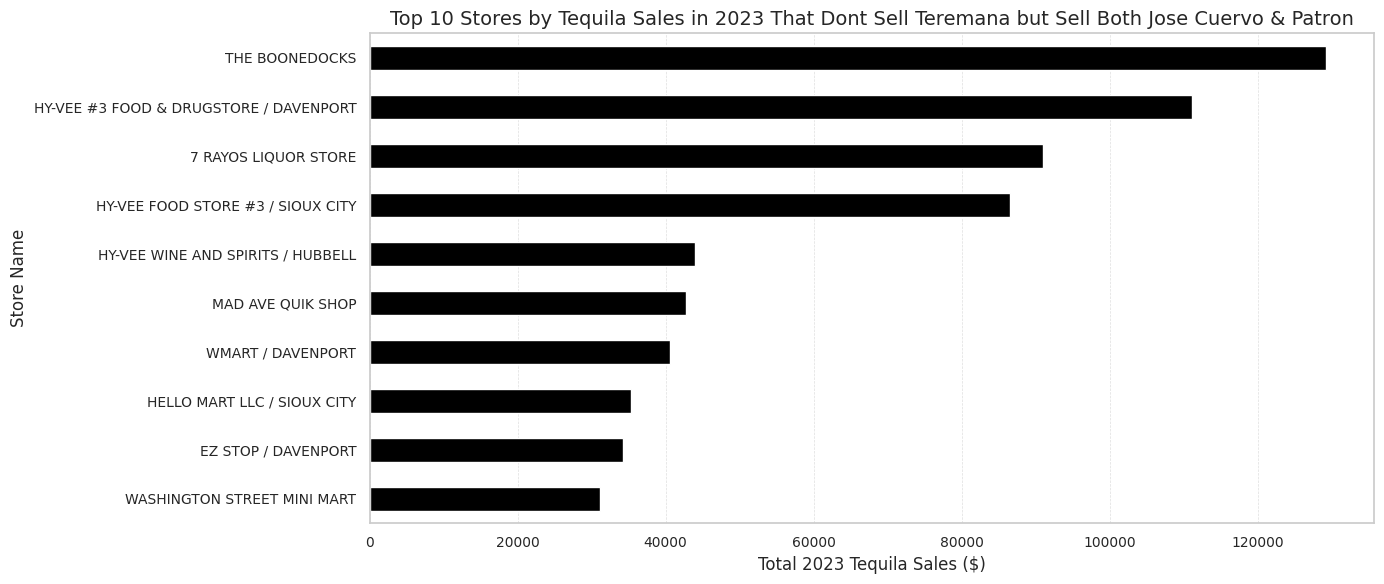

In [69]:
# filter the DataFrame for these stores and for the year 2023
qualified_sales_data = tequila_df[(tequila_df['store_name'].isin(qualified_2023_stores)) & (tequila_df['year'] == 2023)]

# aggregate sales by store
total_sales_per_store = qualified_sales_data.groupby('store_name')['sale_(dollars)_cost'].sum()

# sort the stores by total sales in descending order and select the top 10
top_10_stores_by_sales = total_sales_per_store.sort_values(ascending=False).head(10)

# ensure the order is descending for plotting
top_10_stores_by_sales = top_10_stores_by_sales.sort_values(ascending=True)

# plotting
plt.figure(figsize=(14, 6))
ax = plt.gca()  # get current axes

# plot the top 10 stores by total sales in 2023 as horizontal bars
top_10_stores_by_sales.plot(kind='barh', ax=ax, color='black')

# set title and labels
plt.title('Top 10 Stores by Tequila Sales in 2023 That Dont Sell Teremana but Sell Both Jose Cuervo & Patron', fontsize=14)
plt.xlabel('Total 2023 Tequila Sales ($)', fontsize=12)
plt.ylabel('Store Name', fontsize=12)

# format x-axis ticks to improve readability
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)

# make the grid less pronounced
ax.xaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.25)
ax.yaxis.grid(False)

# optimize spacing
plt.tight_layout()

# display the plot
plt.show()

The top 10 stores by total tequila sales, that sell both Jose Cuervo and Patron but not Teremana, are highlighted above. The top 4 stores show significantly higher sales and consist of: The Boonedocks, Hy-Vee #3 Food & Drugstore / Davenport, 7 Rayos Liquor Store, and Hy-Vee Food Store #3 / Sioux City. These 4 stores would be ideal candidates for Teremana to target for expansion.